# CME rate

cme_rate.py
https://github.com/cmoestl/heliocats
analyses ICMECAT data for CME rate paper Möstl et al. 2020 ApJ (in prep.)

Author: C. Moestl, IWF Graz, Austria; twitter @chrisoutofspace; https://github.com/cmoestl

**work in progress, last update July 2020**

For installation of a conda environment to run this code and how to download the data into a directory specified in config.py, see instructions in README.md of the heliocats github repo. Conda dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in results/plots_rate/ as png and pdf. Full run time for this notebook is about 1 minute on a 2018 macbook pro.


**Data sources**

McIntosh et al. 2020
https://arxiv.org/abs/2006.15263

NOAA solar cycle prediction 2019 (go to "data" on the bottom)
https://www.swpc.noaa.gov/products/solar-cycle-progression

Richardson and Cane ICME list
http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm

Sunspot numbers from SIDC SILSO
http://www.sidc.be/silso/datafiles


In situ data need to be downloaded into a directory defined in config.py from this figshare repository:
https://doi.org/10.6084/m9.figshare.11973693.v7
(which can also be cited by DOI).

---

**MIT LICENSE**

Copyright 2020, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [1]:
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import astropy

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path
#reload again while debugging

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_rate.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots_rate'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
plt.rcParams["figure.figsize"] = (15,8)

## 1 Settings and load data

In [2]:
plt.close('all')

print('cme_rate main program.')
print('Christian Moestl et al., IWF Graz, Austria')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3

#set for loading
load_data=1
get_new_sunspots=0


if load_data > 0:
    
    print('load data (takes a minute or so)')
    print('')
    
    #####################
    print('get RC ICME list')    
    #download richardson and cane list
    rc_url='http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm'

    try: urllib.request.urlretrieve(rc_url,data_path+'rc_list.htm')
    except urllib.error.URLError as e:
        print('Failed downloading ', rc_url,' ',e)

    #read RC list into pandas dataframe    
    rc_dfull=pd.read_html(data_path+'rc_list.htm')
    rc_df=rc_dfull[0]
  

    ##################
    print('get sunspot number from SIDC')    
    #get daily sunspot number from SIDC
    #http://www.sidc.be/silso/datafiles
    #
    #http://www.sidc.be/silso/infosndtot
    #daily sunspot number

    if get_new_sunspots==1:
        ssn=pd.read_csv('data/SN_d_tot_V2.0.csv',sep=';')
        ssn_time=np.zeros(len(ssn))
        for k in np.arange(len(ssn)):
            ssn_time[k]=parse_time(str(ssn.year[k])+'-'+str(ssn.month[k])+'-'+str(ssn.day[k])).plot_date

        print('time convert done')
        ssn.insert(0,'time',ssn_time)
        ssn.spot.loc[np.where(ssn.spot< 0)[0]]=np.nan    
        ssn.stand.loc[np.where(ssn.stand< 0)[0]]=np.nan    
        fileout='ssn.p'
        pickle.dump(ssn, open(data_path+fileout, "wb"))

    file='ssn.p'  
    ssn=pickle.load(open(data_path+file, "rb"))
    
    #make 12 month running mean
    runmean_months=12.0
    ssn_mean_12=hs.running_mean(ssn.spot,int(np.rint(30.42*runmean_months+1)))
    ssn_std_12=hs.running_mean(ssn.stand,int(np.rint(30.42*runmean_months+1)))    

    ssn.insert(1,'spot_mean_12',ssn_mean_12)    
    ssn.insert(2,'spot_std_12',ssn_std_12)    
    
    print('SIDC sunspots done')

    
    ################## Spacecraft
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    

    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )
    
    filevex='vex_2007_2014_sceq.p'
    [vexnon,hvexnon]=pickle.load(open(data_path+filevex, 'rb' ) )
    

    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )

    filemes='messenger_2007_2015_sceq.p'
    [mesnon,hmesnon]=pickle.load(open(data_path+filemes, 'rb' ) )

 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
             
    filesta='stereoa_2007_2019_sceq.p'
    [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

    filepsp='psp_2018_2019_sceq.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )  
    
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) ) 
    
    fileomni='omni_1963_2020.p'
    [omni,homni]=pickle.load(open(data_path+fileomni, "rb" ) ) 

    print('load all data done')

    
# ############# get positions from a 
# # pre-made IDL sav file for older spacecraft positions
# print()
# print('get positions')
# pos = hs.getcat('data/positions_2007_2023_HEEQ_6hours.sav')
# pos_time= hs.decode_array(pos.time) 
# pos_time_num=parse_time(pos_time).plot_date 
# print('positions done')


########### load ICMECAT v2.0, made with icmecat.py or ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()

################### get indices of events for each spacecraft

mercury_orbit_insertion_time= parse_time('2011-03-18').datetime

#spacecraft near the 4 terrestrial planets
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', ic.icme_start_time > mercury_orbit_insertion_time))[0]
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    

#other spacecraft
#all MESSENGER events including cruise phase
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   

############### set limits of solar minimum, rising/declining phase and solar maximum

# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#24    2008   12    2.2   2014 04   116.4  

solarmin=parse_time('2008-12-01').datetime
minstart=solarmin-datetime.timedelta(days=366*1.5)
minend=solarmin+datetime.timedelta(days=365)
minstart_num=parse_time(minstart).plot_date
minend_num=parse_time(minend).plot_date

solarmax=parse_time('2014-04-01').datetime
maxstart=solarmax-datetime.timedelta(days=365*3)
maxend=solarmax+datetime.timedelta(days=365/2)
maxstart_num=parse_time(maxstart).plot_date
maxend_num=parse_time(maxend).plot_date


#rising phase not used
# risestart=parse_time('2010-01-01').datetime
# riseend=parse_time('2011-06-30').datetime
# risestart_num=parse_time('2010-01-01').plot_date
# riseend_num=parse_time('2011-06-30').plot_date

# declstart=parse_time('2015-01-01').datetime
# declend=parse_time('2018-12-31').datetime
# declstart_num=parse_time('2015-01-01').plot_date
# declend_num=parse_time('2018-12-31').plot_date


############### extract events by limits of solar minimum and  maximum
iall_min=np.where(np.logical_and(ic.icme_start_time > minstart,ic.icme_start_time < minend))[0]
#iall_rise=np.where(np.logical_and(ic.icme_start_time > risestart,ic.icme_start_time < riseend))[0]
iall_max=np.where(np.logical_and(ic.icme_start_time > maxstart,ic.icme_start_time < maxend))[0]

wini_min=iall_min[np.where(ic.sc_insitu[iall_min]=='Wind')]
#wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
wini_max=iall_max[np.where(ic.sc_insitu[iall_max]=='Wind')]

vexi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='VEX')]
#vexi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='VEX')]
vexi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='VEX')]

mesi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='MESSENGER')]
#mesi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='MESSENGER')]
mesi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='MESSENGER')]

stai_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-A')]
#stai_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-A')]
stai_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-A')]

stbi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-B')]
#stbi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-B')]
stbi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-B')]

# select the events at Mercury extra after orbit insertion, note that no events available for solar minimum
merci_min=iall_min[np.where(np.logical_and(ic.sc_insitu[iall_min] =='MESSENGER',ic.icme_start_time[iall_min] > parse_time('2011-03-18').datetime))]
#merci_rise=iall_rise[np.where(np.logical_and(ic.sc_insitu[iall_rise] =='MESSENGER',ic.icme_start_time[iall_rise] > parse_time('2011-03-18').datetime))]
merci_max=iall_max[np.where(np.logical_and(ic.sc_insitu[iall_max] =='MESSENGER',ic.icme_start_time[iall_max] > parse_time('2011-03-18').datetime))]

print('done')

cme_rate main program.
Christian Moestl et al., IWF Graz, Austria
load data (takes a minute or so)

get RC ICME list
get sunspot number from SIDC
SIDC sunspots done
load and merge Wind data HEEQ
Wind merging done
load all data done

loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'shea

In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_PSP_MOESTL_20181030_01,PSP,2018-10-30 20:25:00,2018-10-30 20:25:00,2018-10-31 08:19:00,0.2645,24.92,0.12,11.90,84.1,...,176.7,30.9,57176.8,17212.1,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_PSP_MOESTL_20181111_01,PSP,2018-11-11 23:51:00,2018-11-11 23:51:00,2018-11-12 05:59:00,0.2545,178.55,-1.12,6.13,98.9,...,168.5,51.3,73074.1,38992.7,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_PSP_MOESTL_20190315_01,PSP,2019-03-15 09:00:00,2019-03-15 12:11:00,2019-03-15 17:49:00,0.5465,-161.32,3.17,8.82,33.4,...,30.2,9.0,23399.7,16991.4,397.1,24.4,49.1,10.7,13.1,3.7
3,ICME_PSP_MOESTL_20190324_01,PSP,2019-03-24 03:45:00,2019-03-24 03:45:00,2019-03-24 17:38:00,0.3858,-148.82,2.03,13.88,34.0,...,52.4,10.1,40375.0,17986.7,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_PSP_MOESTL_20190725_01,PSP,2019-07-25 08:13:00,2019-07-25 08:13:00,2019-07-25 23:06:00,0.7739,49.91,3.89,14.88,13.7,...,19.9,6.8,77095.2,40614.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,ICME_MAVEN_MOESTL_20160721_01,MAVEN,2016-07-21 15:48:00,2016-07-21 15:48:00,2016-07-23 07:34:00,1.4460,-24.03,1.04,39.77,7.3,...,1.0,0.4,558630.0,457819.5,NaN,NaN,NaN,NaN,NaN,NaN
735,ICME_MAVEN_MOESTL_20160907_01,MAVEN,2016-09-07 18:01:00,2016-09-08 12:31:00,2016-09-09 11:41:00,1.3997,-42.00,3.62,41.67,7.5,...,5.1,3.4,136514.3,33306.2,419.2,22.1,4.4,1.6,1.4,0.6
736,ICME_MAVEN_MOESTL_20170119_01,MAVEN,2017-01-19 05:53:00,2017-01-19 05:53:00,2017-01-20 23:08:00,1.4258,-91.69,4.75,41.25,5.5,...,2.6,0.8,223914.2,217699.9,NaN,NaN,NaN,NaN,NaN,NaN
737,ICME_MAVEN_MOESTL_20170303_01,MAVEN,2017-03-03 17:46:00,2017-03-03 17:46:00,2017-03-05 10:57:00,1.4763,-110.84,3.01,41.18,14.9,...,3.2,1.1,713452.5,322450.8,NaN,NaN,NaN,NaN,NaN,NaN


## 2  ICME rate for solar cycles 23/24 from the Heliophysics System Observatory (ICMECAT and Richardson and Cane)

### Check data days available each year for each planet or spacecraft

In [4]:
######################## make bin for each year for yearly histograms
#define dates of January 1 from 2007 to end year

last_year=2020 #2020 means last date is 2019 Dec 31

years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year) ] 
yearly_start_times=parse_time(years_jan_1_str).datetime
yearly_start_times_num=parse_time(years_jan_1_str).plot_date

#same for July 1 as middle of the year
years_jul_1_str=[str(i)+'-07-01' for i in np.arange(2007,last_year) ] 
yearly_mid_times=parse_time(years_jul_1_str).datetime
yearly_mid_times_num=parse_time(years_jul_1_str).plot_date

#same for december 31
years_dec_31_str=[str(i)+'-12-31' for i in np.arange(2007,last_year) ] 
yearly_end_times=parse_time(years_dec_31_str).datetime
yearly_end_times_num=parse_time(years_dec_31_str).plot_date



########### define arrays for total data days and fill with nan
total_data_days_yearly_win=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_win.fill(np.nan)

total_data_days_yearly_sta=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_sta.fill(np.nan)

total_data_days_yearly_stb=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_stb.fill(np.nan)

total_data_days_yearly_mes=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mes.fill(np.nan)

total_data_days_yearly_vex=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_vex.fill(np.nan)

total_data_days_yearly_mav=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mav.fill(np.nan)


######################## go through each year and search for available data
#time is available for all dates, so there are no NaNs in time, thus need to search for all not NaNs in Btotal variable

for i in range(np.size(yearly_mid_times)):

    print(yearly_start_times[i])

    #get indices of Wind time for the current year
    thisyear=np.where(np.logical_and((win.time > yearly_start_times[i]),(win.time < yearly_end_times[i])))[0]
    #get np.size of available data for each year
    datas=np.size(np.where(np.isnan(win.bt[thisyear])==False))
    #wind is  in 1 minute resolution until 31 Dec 2017, from 1 Jan 2018 its 2 minutes
    min_in_days=1/(60*24)
    if i > 10: min_in_days=1/(60*24)  
    #calculate available days from number of datapoints (each 1 minute) 
    #divided by number of minutes in 1 days
    #this should only be the case if data is available this year, otherwise set to NaN
    if datas > 0: total_data_days_yearly_win[i]=datas*min_in_days
   
    #manual override because Wind data for 2018 and 2019 are heavily despiked
    total_data_days_yearly_win[-1]=360
    total_data_days_yearly_win[-2]=360


    #all other data is in 1 min resolution      
    min_in_days=1/(60*24)

    #same for STEREO-A
    thisyear=np.where(np.logical_and((sta.time > yearly_start_times[i]),(sta.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(sta.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_sta[i]=datas*min_in_days

    #same for STEREO-B
    thisyear=np.where(np.logical_and((stb.time > yearly_start_times[i]),(stb.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(stb.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_stb[i]=datas*min_in_days

    #same for MESSENGER
    thisyear=np.where(np.logical_and((mesnon.time > yearly_start_times[i]),(mesnon.time < yearly_end_times[i])))
    datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_mes[i]=datas*min_in_days

    #same for Mercury alone with non-removed dataset
    #start with 2011
    #   if i == 4: 
    #    thisyear=np.where(np.logical_and((mesnon.time > mercury_orbit_insertion_time),(mesnon.time < yearly_end_times[i])))[0]
    #    datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
    #    if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
    #   #2012 onwards 
    #   if i > 4: 
    #    thisyear=np.where(np.logical_and((mesnon.time > yearly_start_times[i]),(mesnon.time < yearly_end_times[i])))
    #    datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
    #    if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
      

    #same for VEX
    thisyear=np.where(np.logical_and((vexnon.time > yearly_start_times[i]),(vexnon.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(vexnon.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_vex[i]=datas*min_in_days

    #for MAVEN different time resolution
    thisyear=np.where(np.logical_and((mav.time > yearly_start_times[i]),(mav.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(mav.bt[thisyear])==False))
    datas_ind=np.where(np.isnan(mav.bt[thisyear])==False)
    #sum all time intervals for existing data points, but avoid counting gaps where diff is > 1 orbit (0.25 days)
    alldiff=np.diff(parse_time(mav.time[datas_ind]).plot_date)
    smalldiff_ind=np.where(alldiff <0.25)  
    if datas >0: total_data_days_yearly_mav[i]=np.sum(alldiff[smalldiff_ind])

        
        
print('Data days each year:')

print()
print('MESSENGER')
print(np.round(total_data_days_yearly_mes,1))
print()
print('VEX at Venus')
print(np.round(total_data_days_yearly_vex,1))
print()
print('Wind')
print(np.round(total_data_days_yearly_win,1))
print()
print('STA')
print(np.round(total_data_days_yearly_sta,1))
print()
print('STB')
print(np.round(total_data_days_yearly_stb,1))
print()
print('MAVEN')
print(np.round(total_data_days_yearly_mav,1))

print()
print('done')

2007-01-01 00:00:00
2008-01-01 00:00:00
2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
Data days each year:

MESSENGER
[138.1  87.9 267.  361.  278.7 227.7 194.1 209.8  76.4   nan   nan   nan
   nan]

VEX at Venus
[340.5 326.6 336.4 315.7 316.4 328.5 317.4 264.    nan   nan   nan   nan
   nan]

Wind
[356.5 357.7 352.5 354.  353.5 355.8 355.7 329.5 351.2 359.6 360.8 360.
 360. ]

STA
[361.  361.9 361.1 356.  357.6 356.5 353.6 238.1 233.7 363.1 333.3 322.2
 239.5]

STB
[361.3 364.1 361.2 345.1 351.  355.5 356.5 261.5   nan   nan   nan   nan
   nan]

MAVEN
[  nan   nan   nan   nan   nan   nan   nan  36.5 225.1 260.1 181.9   nan
   nan]

done


### get yearly ICME rates at each spacecraft

corrected ICME rates for years
[datetime.datetime(2007, 7, 1, 0, 0) datetime.datetime(2008, 7, 1, 0, 0)
 datetime.datetime(2009, 7, 1, 0, 0) datetime.datetime(2010, 7, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)
 datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)
 datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)
 datetime.datetime(2017, 7, 1, 0, 0) datetime.datetime(2018, 7, 1, 0, 0)
 datetime.datetime(2019, 7, 1, 0, 0)]
MESSENGER [10.6  4.2 10.9  6.1 23.6 30.5 22.6 26.1 19.1  nan  nan  nan  nan]
VEX [ 9.7  1.1 11.9 16.2 20.8 17.8 15.  15.2  nan  nan  nan  nan  nan]
Wind [ 7.2  5.1 15.5 15.5 22.7 30.8 21.6 16.6 14.6  9.1 10.1  8.1  6.1]
STA [ 4.   6.1  9.1 13.3 32.7 37.9 41.3 44.5  4.7  6.  12.1  6.8 19.8]
STB [ 5.1  8.  13.1 16.9 29.1 33.9 29.7 25.1  nan  nan  nan  nan  nan]
MAVEN [nan nan nan nan nan nan nan nan 4.9 5.6 6.  nan nan]


calculate ICME rate matrix std, mean, max, min


,year,std1,median1,mean1,max1,min1
0,732858.0,2.5,7.2,7.3,10.6,4.0
1,733224.0,2.3,5.1,4.9,8.0,1.1
2,733589.0,2.1,11.9,12.1,15.5,9.1
3,733954.0,3.9,15.5,13.6,16.9,6.1
4,734319.0,4.4,23.6,25.8,32.7,20.8
5,734685.0,6.7,30.8,30.2,37.9,17.8
6,735050.0,8.9,22.6,26.0,41.3,15.0
7,735415.0,10.5,25.1,25.5,44.5,15.2
8,735780.0,6.2,9.8,10.8,19.1,4.7
9,736146.0,1.6,6.0,6.9,9.1,5.6


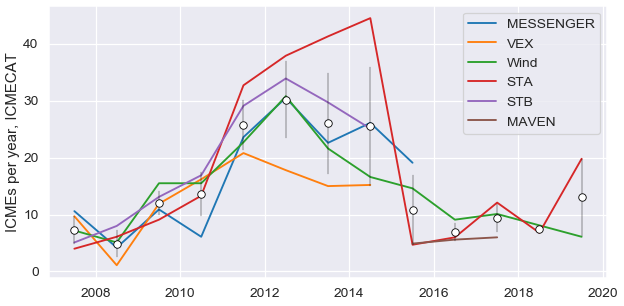

In [5]:
#define dates of January 1 from 2007 to 2020
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year+1) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date
#bin width in days         
binweite=365/8

(histmes1, bin_edgesmes)= np.histogram(mdates.date2num(ic.icme_start_time[mesi]), yearly_bin_edges)
(histvex1, bin_edgesvex) = np.histogram(mdates.date2num(ic.icme_start_time[vexi]), yearly_bin_edges)
(histwin1, bin_edgeswin) = np.histogram(mdates.date2num(ic.icme_start_time[wini]), yearly_bin_edges)
(histmav1, bin_edgesmav) = np.histogram(mdates.date2num(ic.icme_start_time[mavi]), yearly_bin_edges)
(histstb1, bin_edgesstb) = np.histogram(mdates.date2num(ic.icme_start_time[stbi]), yearly_bin_edges)
(histsta1, bin_edgessta) = np.histogram(mdates.date2num(ic.icme_start_time[stai]), yearly_bin_edges)
binedges=bin_edgeswin

#normalize each dataset for data gaps, so correcting ICME rate for actual data availability
#note that for VEX and MESSENGER this was done with the non-removed datasets (vexnon, mesnon)
histvex=np.round(histvex1/total_data_days_yearly_vex*365.24,1)
histmes=np.round(histmes1/total_data_days_yearly_mes*365.24,1)

#ok for these spacecraft as continously in the solar wind and the MAVEN data set is made without orbit gaps
histsta=np.round(histsta1/total_data_days_yearly_sta*365.24,1)
histstb=np.round(histstb1/total_data_days_yearly_stb*365.24,1)
histwin=np.round(histwin1/total_data_days_yearly_win*365.24,1)
histmav=np.round(histmav1/total_data_days_yearly_mav*365.24,1)
histmav[7]=np.nan #not enough data for 2014

print('corrected ICME rates for years')
print(yearly_mid_times)
print('MESSENGER',histmes)
print('VEX',histvex)
print('Wind',histwin)
print('STA',histsta)
print('STB',histstb)
print('MAVEN',histmav)


sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(11,figsize=(12,6),dpi=60)

plt.ylabel('ICMEs per year, ICMECAT')
plt.plot(yearly_mid_times,histmes,'-',label='MESSENGER')
plt.plot(yearly_mid_times,histvex,'-',label='VEX')
plt.plot(yearly_mid_times,histwin,'-',label='Wind')
plt.plot(yearly_mid_times,histsta,'-',label='STA')
plt.plot(yearly_mid_times,histstb,'-',label='STB')
plt.plot(yearly_mid_times,histmav,'-',label='MAVEN')
plt.legend(loc=1)




################### calculate general parameters


print()
print()
print('calculate ICME rate matrix std, mean, max, min')

#arrange icmecat rate data so each row contains std, mean, max, min

icrate=pd.DataFrame(np.zeros([len(yearly_mid_times),6]), columns=['year','std1', 'median1','mean1', 'max1', 'min1'] )


for i in np.arange(0,len(yearly_mid_times)):
    
    icrate.at[i,'year']=yearly_mid_times_num[i]
    icrate.at[i,'median1']=np.round(np.nanmedian([histwin[i],histvex[i],histsta[i],histstb[i],histmes[i],histmav[i]]),1)
    icrate.at[i,'mean1']=np.round(np.nanmean([histwin[i],histvex[i],histsta[i],histstb[i],histmes[i],histmav[i]]),1)
    icrate.at[i,'std1']=np.round(np.nanstd([histwin[i],histvex[i],histsta[i],histstb[i],histmes[i],histmav[i]]),1)
    icrate.at[i,'max1']=np.nanmax([histwin[i],histvex[i],histsta[i],histstb[i],histmes[i],histmav[i]])
    icrate.at[i,'min1']=np.nanmin([histwin[i],histvex[i],histsta[i],histstb[i],histmes[i],histmav[i]])

plt.plot([icrate.year,icrate.year],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=0.5)
plt.plot(icrate.year,icrate.mean1,'ok',markerfacecolor='white')

# icrate=pd.DataFrame(np.zeros([len(histvex)*6,3]), columns=['year','rate','sc'] )
# #write all icme rates into this array
# icrate.at[0:12,'rate']=histmes
# icrate.at[0:12,'year']=yearly_start_times_num
# icrate.at[0:12,'sc']='MESSENGER'

# icrate.at[13:25,'rate']=histvex
# icrate.at[13:25,'year']=yearly_start_times_num
# icrate.at[13:25,'sc']='VEX'

# icrate.at[26:38,'rate']=histwin
# icrate.at[26:38,'year']=yearly_start_times_num
# icrate.at[26:38,'sc']='Wind'

# icrate.at[39:51,'rate']=histvex
# icrate.at[39:51,'year']=yearly_start_times_num
# icrate.at[39:51,'sc']='STA'

# icrate.at[52:64,'rate']=histvex
# icrate.at[52:64,'year']=yearly_start_times_num
# icrate.at[52:64,'sc']='STB'

# icrate.at[65:77,'rate']=histvex
# icrate.at[65:77,'year']=yearly_start_times_num
# icrate.at[65:77,'sc']='MAVEN'

# sns.boxplot(x='year',y='rate',data=icrate)



icrate



### get Richardson and Cane ICME rate for comparison

[ 4 22 36 33 51 48 26 22 21 31 13  2  3 11 15 32 35 25 20 30 13  9  8  5]
[1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.]
[datetime.datetime(1996, 7, 1, 0, 0) datetime.datetime(1997, 7, 1, 0, 0)
 datetime.datetime(1998, 7, 1, 0, 0) datetime.datetime(1999, 7, 1, 0, 0)
 datetime.datetime(2000, 7, 1, 0, 0) datetime.datetime(2001, 7, 1, 0, 0)
 datetime.datetime(2002, 7, 1, 0, 0) datetime.datetime(2003, 7, 1, 0, 0)
 datetime.datetime(2004, 7, 1, 0, 0) datetime.datetime(2005, 7, 1, 0, 0)
 datetime.datetime(2006, 7, 1, 0, 0) datetime.datetime(2007, 7, 1, 0, 0)
 datetime.datetime(2008, 7, 1, 0, 0) datetime.datetime(2009, 7, 1, 0, 0)
 datetime.datetime(2010, 7, 1, 0, 0) datetime.datetime(2011, 7, 1, 0, 0)
 datetime.datetime(2012, 7, 1, 0, 0) datetime.datetime(2013, 7, 1, 0, 0)
 datetime.datetime(2014, 7, 1, 0, 0) datetime.datetime(2015, 7, 1, 0, 0)
 datetime.datetime(2016, 7, 1, 0, 0) datetime.dat

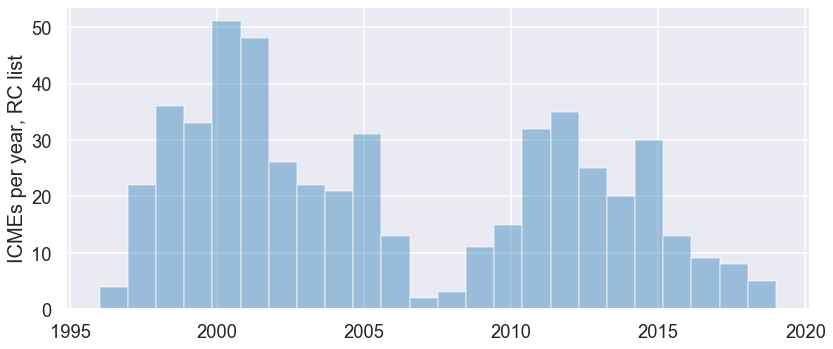

In [6]:
#convert times in dataframe from richardson and cane list to numpy array
r1=np.array(rc_df['Disturbance Y/M/D (UT) (a)'])

#to get ICME rate, go through all rows
rc_year=np.zeros(len(r1))

#extract string and check whether its a viable float and non nan:
for p in np.arange(0,len(r1)):    
    rc_yearstr=str(r1[p,0])    
    if hs.is_float(rc_yearstr[0:4]):
        if np.isfinite(float(rc_yearstr[0:4])):
            rc_year[p]=float(rc_yearstr[0:4]) #rc_year contains all ICME

rc_year.sort() 
rc_icme_per_year=np.trim_zeros(rc_year)
#print(rc_year)

sns.set_style('darkgrid')
#plot check whats in this array
fig=plt.figure(12,figsize=(12,5),dpi=80)
ax11=sns.distplot(rc_icme_per_year,bins=24,kde=None)
plt.ylabel('ICMEs per year, RC list')

#get yearly ICME rate (use range to get correct numbers)
rc_rate_values=np.histogram(rc_icme_per_year,bins=24,range=(1996,2020))[0]
#cutoff 2020
rc_rate_time=np.histogram(rc_icme_per_year,bins=24,range=(1996,2020))[1][0:-1]

print(rc_rate_values)
print(rc_rate_time)

years_jul_1_str_rc=[str(i)+'-07-01' for i in np.arange(1996,2020) ] 
yearly_mid_times_rc=parse_time(years_jul_1_str_rc).datetime
yearly_mid_times_num_rc=parse_time(years_jul_1_str_rc).plot_date
print(yearly_mid_times_rc)
#plt.figure(2)
#plt.plot(yearly_mid_times_rc,rc_rate_values)



### **Figure 1** plot ICME frequency cycle 24

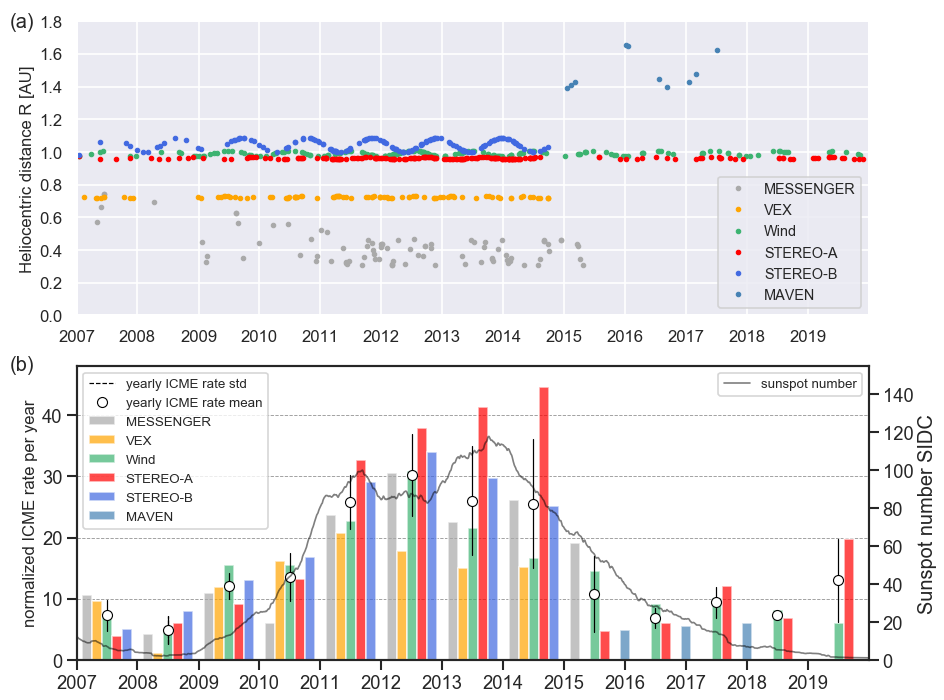

In [7]:
sns.set_context("talk")     
sns.set_style('darkgrid')
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=80)

######################## Fig 1a - sc positions during ICMEs vs time
ax1 = plt.subplot(211) 
msize=4
plt.plot_date(ic.icme_start_time[mesi],ic.mo_sc_heliodistance[mesi],fmt='o',color='darkgrey',markersize=msize,label='MESSENGER')
plt.plot_date(ic.icme_start_time[vexi],ic.mo_sc_heliodistance[vexi],fmt='o',color='orange',markersize=msize,label='VEX')
plt.plot_date(ic.icme_start_time[wini],ic.mo_sc_heliodistance[wini],fmt='o',color='mediumseagreen',markersize=msize,label='Wind')
plt.plot_date(ic.icme_start_time[stai],ic.mo_sc_heliodistance[stai],fmt='o',color='red',markersize=msize,label='STEREO-A')
plt.plot_date(ic.icme_start_time[stbi],ic.mo_sc_heliodistance[stbi],fmt='o',color='royalblue',markersize=msize,label='STEREO-B')
plt.plot_date(ic.icme_start_time[mavi],ic.mo_sc_heliodistance[mavi],fmt='o',color='steelblue',markersize=msize,label='MAVEN')
plt.legend(loc=4,fontsize=13)

plt.ylabel('Heliocentric distance R [AU]',fontsize=fsize)
plt.xticks(yearly_start_times,fontsize=fsize) 
plt.xlim(yearly_bin_edges[0],yearly_bin_edges[-1])
plt.ylim([0,1.7])
plt.yticks(np.arange(0,1.9,0.2),fontsize=fsize) 

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)


#################### Fig 1b
sns.set_style("ticks",{'grid.linestyle': '--'})

ax2 = plt.subplot(212) 

ax3=ax2.twinx()
ax3.plot(ssn.time,ssn.spot_mean_12,'-k',alpha=0.5,linewidth=1.5,label='sunspot number')
ax3.set_ylabel('Sunspot number SIDC')
ax3.set_ylim(0,155)
ax3.legend(loc=1,fontsize=12)

#grid for icme rate
for i in np.arange(0,50,10):
    ax2.plot([datetime.datetime(2007,1,1),datetime.datetime(2020,1,1)],np.zeros(2)+i,linestyle='--',color='k',alpha=0.4,lw=0.8,zorder=0)

binweite=int(np.round(360/6))
bin_edges=bin_edgeswin[:-1]
alp=0.7
ax2.bar(bin_edges+5+binweite,histmes, width=binweite,color='darkgrey', alpha=alp,label='MESSENGER')
ax2.bar(bin_edges+5+binweite*2,histvex, width=binweite,color='orange', alpha=alp,label='VEX')
ax2.bar(bin_edges+5+binweite*3,histwin, width=binweite,color='mediumseagreen', alpha=alp,label='Wind')
#ax2.bar(bin_edgeswin[:-1]+5+binweite*3,rc_rate_values[-14:-1], width=binweite,color='darkgreen', alpha=0.8,label='Wind')
ax2.bar(bin_edges+5+binweite*4,histsta, width=binweite,color='red', alpha=alp,label='STEREO-A')
ax2.bar(bin_edges+5+binweite*5,histstb, width=binweite,color='royalblue', alpha=alp,label='STEREO-B')
ax2.bar(bin_edges+5+binweite*6,histmav, width=binweite,color='steelblue', alpha=alp,label='MAVEN')


#ax2.boxplot(histmes)
#RC values
#ax2.plot(bin_edgeswin[:-1]+5+binweite*3,rc_rate_values[-14:-1],'ok',markerfacecolor='white',marker='o',markersize=5,label='Earth RC list')


#mean and standard deviation and min max
ax2.plot([icrate.year,icrate.year],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=1.1)
ax2.plot([icrate.year[1],icrate.year[1]],[icrate.mean1[1]-icrate.std1[1],icrate.mean1[1]+icrate.std1[1]],'--k',lw=1.1,label='yearly ICME rate std')
#ax2.plot([icrate.year,icrate.year],[icrate.min1,icrate.max1],'--k',lw=1.1)
ax2.plot(icrate.year,icrate.mean1,'ok',markerfacecolor='white',label='yearly ICME rate mean')



ax2.set_ylim(0,48)
ax2.set_xlim(yearly_bin_edges[0],yearly_bin_edges[-1])
ax2.legend(loc=2,fontsize=12)

fsize=15
ax2.set_ylabel('normalized ICME rate per year',fontsize=fsize)
#ax2.set_yticks(fontsize=fsize) 

ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
plt.xticks(yearly_start_times, fontsize=fsize) 
plt.xlabel('Year',fontsize=fsize)

plt.tight_layout()

plt.annotate('(a)',[0.01,0.96],xycoords='figure fraction')
plt.annotate('(b)',[0.01,0.47],xycoords='figure fraction')

plt.savefig('results/plots_rate/fig1_icme_rate_hso.pdf', dpi=300)
plt.savefig('results/plots_rate/fig1_icme_rate_hso.png', dpi=300)

# 3 get solar cycle results on ICME rates and sunspot numbers

## solar cycle 23

In [8]:
print('cycle 23\n')


############################# times
print('times:')
#these years cover solar cycle 23
years23=np.arange(1996,2009)
print(years23)

last_year=years23[-1] 

years_jan_1_str_23=[str(i)+'-01-01' for i in np.arange(1996,last_year+1) ] 
yearly_start_times_23=parse_time(years_jan_1_str_23).datetime
yearly_start_times_num_23=parse_time(years_jan_1_str_23).plot_date

#same for July 1 as middle of the year
years_jul_1_str_23=[str(i)+'-07-01' for i in np.arange(1996,last_year+1) ] 
yearly_mid_times_23=parse_time(years_jul_1_str_23).datetime
yearly_mid_times_num_23=parse_time(years_jul_1_str_23).plot_date


print(yearly_mid_times_23)

#same for december 31
years_dec_31_str_23=[str(i)+'-12-31' for i in np.arange(1996,last_year+1) ] 
yearly_end_times_23=parse_time(years_dec_31_str_23).datetime
yearly_end_times_num_23=parse_time(years_dec_31_str_23).plot_date


# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#1996   08   11.2   2001 11  180.3   12  04

solarmin23=parse_time('1996-08-01').datetime
# minstart_23=solarmin_23-datetime.timedelta(days=366*1.5)
# minend=solarmin+datetime.timedelta(days=365)
# minstart_num=parse_time(minstart).plot_date
# minend_num=parse_time(minend).plot_date

solarmax23=parse_time('2001-11-01').datetime
# maxstart=solarmax-datetime.timedelta(days=365*3)
# maxend=solarmax+datetime.timedelta(days=365/2)
# maxstart_num=parse_time(maxstart).plot_date
# maxend_num=parse_time(maxend).plot_date

print('min/max',solarmin23,solarmax23)
print()


#################### spots 
#get yearly smoothed 12 month spot rate 

spots23=np.zeros(len(years23))
counter=0
for q in years23:
    spots23[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots:')
print('spots yearly mean', np.rint(spots23))
print()


#################### ICME rate
#number of MFR events in Wind ICME catalog, 
#for years as in yearly_mid_times_23 but start aug 1996 and end with 
#nov 2008 #note : halloween events at ACE! Wind not?
wind_mfr_number_23=[2,8,29,11,30,21,20,6,12,16,13,7,3]
#wind_mfr_number_23_err=[2,8,29,11,30,21,20,6,12,16,13,7,3]


rc_rate23=rc_rate_values[0:13]


print('icme rate:')
print('icmes RC',rc_rate23)
print()

cycle 23

times:
[1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]
[datetime.datetime(1996, 7, 1, 0, 0) datetime.datetime(1997, 7, 1, 0, 0)
 datetime.datetime(1998, 7, 1, 0, 0) datetime.datetime(1999, 7, 1, 0, 0)
 datetime.datetime(2000, 7, 1, 0, 0) datetime.datetime(2001, 7, 1, 0, 0)
 datetime.datetime(2002, 7, 1, 0, 0) datetime.datetime(2003, 7, 1, 0, 0)
 datetime.datetime(2004, 7, 1, 0, 0) datetime.datetime(2005, 7, 1, 0, 0)
 datetime.datetime(2006, 7, 1, 0, 0) datetime.datetime(2007, 7, 1, 0, 0)
 datetime.datetime(2008, 7, 1, 0, 0)]
min/max 1996-08-01 00:00:00 2001-11-01 00:00:00

spots:
spots yearly mean [ 12.  29.  88. 136. 174. 170. 164.  99.  65.  46.  25.  13.   4.]

icme rate:
icmes RC [ 4 22 36 33 51 48 26 22 21 31 13  2  3]



## solar cycle 24

In [9]:
print('cycle 24\n')

#################### times
print('times:')
#these years cover solar cycle 23
years24=np.arange(2009,2020)
print(years24)

#same for July 1 as middle of the year
last_year=2020
years_jul_1_str_24=[str(i)+'-07-01' for i in np.arange(2009,last_year) ] 
yearly_mid_times_24=parse_time(years_jul_1_str_24).datetime
yearly_mid_times_num_24=parse_time(years_jul_1_str_24).plot_date
print(yearly_mid_times_24)
print()


#################### spots 
print('spots:')

#get yearly smoothed 12 month spot rate 
spots24=np.zeros(len(years24))
counter=0
for q in years24:
    spots24[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots yearly mean:', np.rint(spots24))
print()

print('----------')

################# ICME rates
print('ICME rate:')
print()

rc_rate24=rc_rate_values[13:]
print(years24)
print('icmes RC',rc_rate24)
print()

ic_rate24=icrate[2:].mean1.to_numpy()
ic_rate24_std=icrate[2:].std1.to_numpy()
print('icmes ICMECAT mean',ic_rate24)
print('icmes ICMECAT std',ic_rate24_std)
icrate_years_24=parse_time(mdates.num2date(icrate.year[2:])).iso
print(icrate_years_24)

print()
print('ratio RC to ICMECAT:')
print(np.round(np.mean(rc_rate24/ic_rate24),2))


cycle 24

times:
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[datetime.datetime(2009, 7, 1, 0, 0) datetime.datetime(2010, 7, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)
 datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)
 datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)
 datetime.datetime(2017, 7, 1, 0, 0) datetime.datetime(2018, 7, 1, 0, 0)
 datetime.datetime(2019, 7, 1, 0, 0)]

spots:
spots yearly mean: [  5.  25.  81.  85.  94. 113.  70.  40.  22.   7.   4.]

----------
ICME rate:

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
icmes RC [11 15 32 35 25 20 30 13  9  8  5]

icmes ICMECAT mean [12.1 13.6 25.8 30.2 26.  25.5 10.8  6.9  9.4  7.4 13. ]
icmes ICMECAT std [ 2.1  3.9  4.4  6.7  8.9 10.5  6.2  1.6  2.5  0.6  6.8]
['2009-07-01 00:00:00.000' '2010-07-01 00:00:00.000'
 '2011-07-01 00:00:00.000' '2012-07-01 00:00:00.000'
 '2013-07-01 00:00:00.000' '2014-07-01 00:00:00.000'
 '2

## **Figure 2** correlation SSN with ICME rate and fit
plot SSN vs ICME rate, linear fit with confidence interval

linear fit SSN vs. ICME rate
LinregressResult(slope=0.20896856839851677, intercept=7.795659965015293, rvalue=0.8437296411023043, pvalue=2.2276281857119034e-07, stderr=0.028343484728813165)
icme_rate[per year] = ( 0.209 +/- 0.028 ) * sunspot number [yearly average] +  7.796
inverse slope: 4.79
Pearson correlation coefficient: 0.84
mean difference icme rate SC23 to predicted rate with linear fit, over full cycle: 0.27 +/- 8.2
mean difference icme rate SC24 to predicted rate with linear fit, over full cycle: -0.32 +/- 5.9



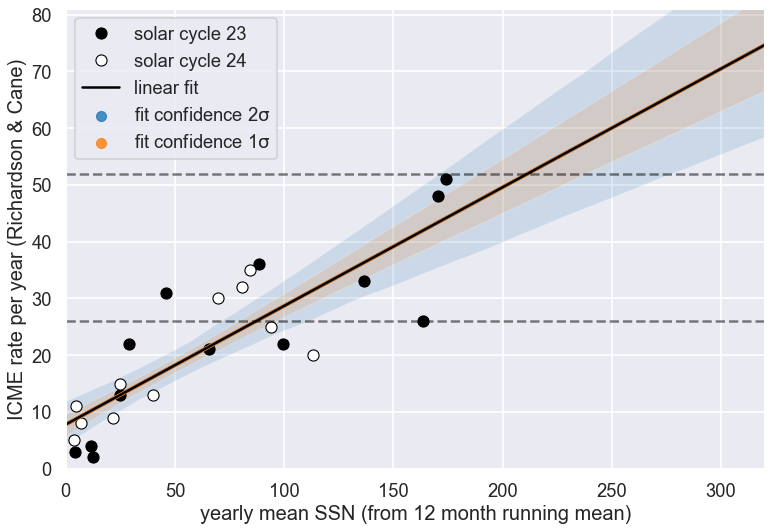

In [10]:
#add spots23/24 and rc_rate23/24 into 1 array for correlation
spots_corr=np.hstack([spots23,spots24])
rc_rate_corr=np.hstack([rc_rate23,rc_rate24])

#quick check with seaborn for correlation
#seaborn uses this :import statsmodels
#kind{ “scatter” | “reg” | “resid” | “kde” | “hex” }, optional
#sns.jointplot(spots_corr,rc_rate_corr,kind='reg',xlim=[0,np.max(spots_corr)+20],ylim=[0,np.max(rc_rate_corr+10)], \
#                  marginal_kws=dict(bins=5, rug=True),x_ci=95).set_axis_labels("yearly mean SSN (12 month running mean)", "ICME rate (Richardson & Cane)")


############################## make linear fit
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
print('linear fit SSN vs. ICME rate')
linfit=scipy.stats.linregress(spots_corr,rc_rate_corr)
print(linfit)
print('icme_rate[per year] = (',np.round(linfit.slope,3),'+/-',np.round(linfit.stderr,3),') * sunspot number [yearly average] + ',np.round(linfit.intercept,3))
print('inverse slope:',np.round(1/linfit.slope,2))
print('Pearson correlation coefficient:',np.round(linfit.rvalue,2))

######################### Function for conversion SSN to ICMERATE, with errors on fit confidence 1 time std

#with these results from the linear fit, make a conversion function from ssn to icme_rate
def ssn_to_rate(ssn,fitresult):    
    rate=linfit.slope*ssn+linfit.intercept    
    rate_low=(linfit.slope-2*linfit.stderr)*ssn+linfit.intercept    
    rate_up=(linfit.slope+2*linfit.stderr)*ssn+linfit.intercept    
    return rate, rate_low, rate_up

print('mean difference icme rate SC23 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots23,linfit)[0]-rc_rate23),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots23,linfit)[0]-rc_rate23),1))#
print('mean difference icme rate SC24 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots24,linfit)[0]-rc_rate24),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots24,linfit)[0]-rc_rate24),1))#
print()


############################ plot figure
sns.set_context("talk")     
sns.set_style('darkgrid')
fsize=15
fig=plt.figure(2,figsize=(10,7),dpi=80)

plt.plot(spots23,rc_rate23,color='black',marker='o',linestyle='',markersize=10,label='solar cycle 23')
plt.plot(spots24,rc_rate24,color='black',markerfacecolor='white',marker='o',linestyle='',markersize=10,label='solar cycle 24')

plt.xlim(0,320)
plt.ylim(0,np.max(rc_rate_corr)+30)
plt.xlabel("yearly mean SSN (from 12 month running mean)")
plt.ylabel("ICME rate per year (Richardson & Cane)")

#errors
#ylinfit_1=(linfit.slope-linfit.stderr)*xlinfit+linfit.intercept
#ylinfit_2=(linfit.slope+linfit.stderr)*xlinfit+linfit.intercept
#plt.plot(xlinfit,ylinfit_1,'--k')
#plt.plot(xlinfit,ylinfit_2,'--k')

#https://seaborn.pydata.org/generated/seaborn.regplot.html
sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=95,label=r'fit confidence 2$\mathrm{\sigma}$')
sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=68,label=r'fit confidence 1$\mathrm{\sigma}$')

xlinfit=np.arange(0,350)
ylinfit=linfit.slope*xlinfit+linfit.intercept
plt.plot(xlinfit,ylinfit,'-k',label='linear fit')
plt.plot(xlinfit,np.zeros(len(xlinfit))+52,'--k',alpha=0.5)
plt.plot(xlinfit,np.zeros(len(xlinfit))+26,'--k',alpha=0.5)

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('results/plots_rate/fig2_rate_ssn.pdf', dpi=300)
plt.savefig('results/plots_rate/fig2_rate_ssn', dpi=300)

## predictions for solar cycle 25: SSN and ICME rate
### 1. Mean cycle model

In [11]:
# from heliocats import stats as hs
# importlib.reload(hs) #reload again while debugging

print('---------------------------------')
print('cycle 25')
print()
print('calculate several Hathaway function models for SSN and predict the ICME rate')
print('')
print('---------------------------------')


############# set yearly times
last_year=2033
years_jan_1_str_25=[str(i)+'-01-01' for i in np.arange(2020,last_year) ] 
yearly_start_times_25=parse_time(years_jan_1_str_25,format='iso').datetime
yearly_start_times_num_25=parse_time(years_jan_1_str_25,format='iso').plot_date

#same for July 1 as middle of the year
years_jul_1_str_25=[str(i)+'-07-01' for i in np.arange(2020,last_year) ] 
yearly_mid_times_25=parse_time(years_jul_1_str_25,format='iso').datetime
yearly_mid_times_num_25=parse_time(years_jul_1_str_25,format='iso').plot_date

#### for smooth plotting daily list of times
#t0 of solar cycler 25 is unclear at time of writing! assumed 2020 june 1
start_25=parse_time('2020-06-01',format='iso').datetime
#not end time of next solar cycle, but end time of plotting
end_25=parse_time('2033-01-01',format='iso').datetime
    
#create an array with 1 day resolution between t start and end
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]  
times_25_daily_mat=mdates.date2num(times_25_daily) 

######################################################## 1. Mean cycle model

#hathaway 2015: t0 minus 4 months is good match
#t0 is start date of cycle
shift_t0=timedelta(days=4*30+1)

print()
print('1. mean cycle')

#mean of all cycles function: Hathaway 1994
#parameters taken from Hathaway 2015 review section 4.5 DOI 10.1007/lrsp-2015-4
#https://link.springer.com/article/10.1007/lrsp-2015-4
#but this is based on different SSN definitions?
# am=195
# amerr=50
# bm=56
# cm=0.8

print('load min max for all cycles from SILSO')

#http://sidc.oma.be/silso/DATA/Cycles/TableCyclesMiMa.txt
#Table of minima, maxima and cycle durations based on
#13-month smoothed monthly mean sunspot numbers (Version 2.0).
mima_num=np.loadtxt('data/TableCyclesMiMa.txt', skiprows=2)
mima = pd.DataFrame(mima_num)
mima.columns = ['cycle','min_year','min_month','min_sn','max_year','max_month','max_sn','dur_year','dur_months']

print()
print('Average maximum sunspot number (SILSO) of all cycles, 13 months smoothed:',np.round(mima.max_sn.mean(),1),' +/- ',np.round(mima.max_sn.std(),1))
print()

#use all parameters as in Hathaway but adjust amplitude to average for the SILSO numbers:
am=342
bm=56
cm=0.8
print('average cycle a,b,c:', am,bm,cm)



#mean of all cycles yearly ssn numbers 
spots_predict_25m=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,am,bm,cm)
#and same for 1 day resolution 
spots_predict_25m_daily=hs.hathaway(times_25_daily, start_25-shift_t0,am,bm,cm)

print('t0 in SC25 PP prediction is:',start_25-shift_t0)
#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25m_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25m_daily)])[0:11])
print()
print(yearly_mid_times_25)
print('spots yearly: ',np.rint(spots_predict_25m))

#yearly icme numbers: convert with function
icmes_predict_25m=ssn_to_rate(spots_predict_25m,linfit)[0]
#same daily resolution
icmes_predict_25m_daily=ssn_to_rate(spots_predict_25m_daily,linfit)[0]



print('icmes yearly: ',np.rint(icmes_predict_25m))

print()
print()
print('Merge error from 1. ssn prediction from fit with 2. spread in icme rate observed with ICMECAT (not used in plots later as PP19 is quite similar)')

#1. error from SSN fit yearly, low and high
icmes_predict_25m_low=ssn_to_rate(spots_predict_25m,linfit)[1]
icmes_predict_25m_high=ssn_to_rate(spots_predict_25m,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_m_std_fit=np.round(icmes_predict_25m-icmes_predict_25m_low,1)
print('error from SSN to ICME fit',ic_rate25_m_std_fit)

#2. error from ICME rate
#assumption icrate_std=2 for last 3 years
ic_rate25_std=np.hstack([ic_rate24_std[0:-1],np.array([2.0,2.0,2.0])])
print('spread in ICME rate from SC24, assuming 2009=> 2020',ic_rate25_std)

#add both errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_m_std=np.round(np.sqrt(ic_rate25_m_std_fit**2+ic_rate25_std**2),1)
print('Std in ICME rate from fit and ICMECAT range for each year:')
print(ic_rate_25_m_std)

---------------------------------
cycle 25

calculate several Hathaway function models for SSN and predict the ICME rate

---------------------------------

1. mean cycle
load min max for all cycles from SILSO

Average maximum sunspot number (SILSO) of all cycles, 13 months smoothed: 178.7  +/-  57.8

average cycle a,b,c: 342 56 0.8
t0 in SC25 PP prediction is: 2020-02-01 00:00:00
max ssn 179.0
at time 2024-12-23 

[datetime.datetime(2020, 7, 1, 0, 0) datetime.datetime(2021, 7, 1, 0, 0)
 datetime.datetime(2022, 7, 1, 0, 0) datetime.datetime(2023, 7, 1, 0, 0)
 datetime.datetime(2024, 7, 1, 0, 0) datetime.datetime(2025, 7, 1, 0, 0)
 datetime.datetime(2026, 7, 1, 0, 0) datetime.datetime(2027, 7, 1, 0, 0)
 datetime.datetime(2028, 7, 1, 0, 0) datetime.datetime(2029, 7, 1, 0, 0)
 datetime.datetime(2030, 7, 1, 0, 0) datetime.datetime(2031, 7, 1, 0, 0)
 datetime.datetime(2032, 7, 1, 0, 0)]
spots yearly:  [  1.  32.  93. 147. 176. 176. 153. 117.  80.  49.  26.  13.   5.]
icmes yearly:  [ 8. 15.

---------------------------- 2. SC25 PP 2019

get PP25 prediction from JSON file from NOAA (2020 May 27) 
Hathaway function fit parameters x0,a,b,c: [-252.3  256.    60.3] 0.35
t0 in SC25 PP prediction is: 2019-09-06 00:00:00+00:00
lower error: Hathaway function fit parameters x0,a,b,c: [-21.8 228.2  54.4] 0.48
higher error: Hathaway function fit parameters x0,a,b,c: [-491.5  273.3   67.4] 0.34
note that high and low error ranges are calculated here with a Hathaway function, small error to PP forecast


max ssn 115.0
at time 2025-07-18 

spots yearly:  [  2.  15.  45.  79. 105. 115. 107.  88.  64.  42.  25.  13.   6.]

Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT
ICME rate error from SSN prediction [0.7  2.06 2.58 2.2  1.72 1.66 2.   2.44 2.65 2.49 2.03 1.45 0.91]
error from SSN to ICME fit [0.1 0.9 2.5 4.5 5.9 6.5 6.1 5.  3.7 2.4 1.4 0.7 0.4]
spread in ICME rate [ 2.1  3.9  4.4  6.7  8.9 10.5  6.2  1.6  2.5  0.6  2.   2.   2. ]

final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:
[ 2.2  4.5  5.7  8.4 10.8 12.5  8.9  5.8  5.2  3.5  3.2  2.6  2.2]


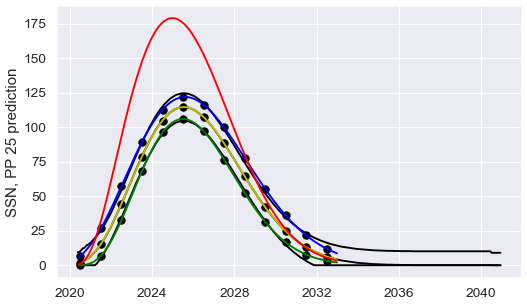

In [12]:
########################################################### 2. SC25 panel prediction (SC25PP)
print('---------------------------- 2. SC25 PP 2019')
print()
print('get PP25 prediction from JSON file from NOAA (2020 May 27) ')    

#download PP25 prediction from NOAA with timestamp
#sc25pp_url='https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'

#try: urllib.request.urlretrieve(sc25pp_url,data_path+'predicted-solar-cycle_2020_may_27.json')
#except urllib.error.URLError as e:
#    print('Failed downloading ', sc25pp_url,' ',e)

pp25_df=pd.read_json('data/predicted-solar-cycle_2020_may_27.json')

#kill first few rows and start with May 2020
pp25_df=pp25_df.drop([0,1,2,3,4,5],axis=0)
pp25_df['time-tag']
pp25_df_times=parse_time(pp25_df['time-tag']).datetime
pp25_df_times_num=parse_time(pp25_df['time-tag']).plot_date
pp25_df_ssn=pp25_df['predicted_ssn']
pp25_df_ssn_high=pp25_df['high_ssn']
pp25_df_ssn_low=pp25_df['low_ssn']

#make hathaway fit
hw_param_pp25 = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn,\
                                        p0=[-300,200,60,1])    
print('Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25[0][0:3],1),np.round(hw_param_pp25[0][3],2))
#get t0 date for hathway function from fit x0
x0fit_in_days=int(np.rint(hw_param_pp25[0][0]))
start_25_fit=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days)
print('t0 in SC25 PP prediction is:',start_25_fit)

# same for low and high
hw_param_pp25_low = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn_low,\
                                        p0=[-300,200,60,1])    
x0fit_in_days_low=int(np.rint(hw_param_pp25_low[0][0]))
start_25_fit_low=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days_low)
print('lower error: Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25_low[0][0:3],1),np.round(hw_param_pp25_low[0][3],2))

hw_param_pp25_high = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn_high,\
                                        p0=[-300,200,60,1])    
x0fit_in_days_high=int(np.rint(hw_param_pp25_high[0][0]))
start_25_fit_high=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days_high)
print('higher error: Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25_high[0][0:3],1),np.round(hw_param_pp25_high[0][3],2))
print('note that high and low error ranges are calculated here with a Hathaway function, small error to PP forecast')


spots_predict_25pp=hs.hathaway(yearly_mid_times_25,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])
spots_predict_25pp_daily=hs.hathaway(times_25_daily,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])

#fit parameters for PP19
#start_25_fit
app=hw_param_pp25[0][1]
bpp=hw_param_pp25[0][2]
cpp=hw_param_pp25[0][3]

spots_predict_25pp_low=hs.hathaway(yearly_mid_times_25,start_25_fit_low,hw_param_pp25_low[0][1],hw_param_pp25_low[0][2],hw_param_pp25_low[0][3])
spots_predict_25pp_daily_low=hs.hathaway(times_25_daily,start_25_fit_low,hw_param_pp25_low[0][1],hw_param_pp25_low[0][2],hw_param_pp25_low[0][3])
spots_predict_25pp_high=hs.hathaway(yearly_mid_times_25,start_25_fit_high,hw_param_pp25_high[0][1],hw_param_pp25_high[0][2],hw_param_pp25_high[0][3])
spots_predict_25pp_daily_high=hs.hathaway(times_25_daily,start_25_fit_high,hw_param_pp25_high[0][1],hw_param_pp25_high[0][2],hw_param_pp25_high[0][3])

plt.figure(12,figsize=(10,6),dpi=60)
plt.plot(pp25_df_times_num,pp25_df_ssn,'-k',markerfacecolor='white')
plt.plot(pp25_df_times,pp25_df['high_ssn'],'-k',markerfacecolor='white')
plt.plot(pp25_df_times,pp25_df['low_ssn'],'-k',markerfacecolor='white')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp,'ok')
plt.plot_date(times_25_daily,spots_predict_25pp_daily,'-y')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp_low,'ok')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp_high,'ok')
plt.plot_date(times_25_daily,spots_predict_25pp_daily_low,'-g')
plt.plot_date(times_25_daily,spots_predict_25pp_daily_high,'-b')
plt.plot_date(times_25_daily,spots_predict_25m_daily,'-r')

plt.ylabel('SSN, PP 25 prediction')
#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25pp_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25pp_daily)])[0:11])
print()
print('spots yearly: ',np.rint(spots_predict_25pp))


#yearly spots numbers
icmes_predict_25pp=ssn_to_rate(spots_predict_25pp,linfit)[0]
icmes_predict_25pp_low=ssn_to_rate(spots_predict_25pp_low,linfit)[0]
icmes_predict_25pp_high=ssn_to_rate(spots_predict_25pp_high,linfit)[0]

#same daily
icmes_predict_25pp_daily=ssn_to_rate(spots_predict_25pp_daily,linfit)[0]
icmes_predict_25pp_daily_low=ssn_to_rate(spots_predict_25pp_daily_low,linfit)[0]
icmes_predict_25pp_dailyhigh=ssn_to_rate(spots_predict_25pp_daily_high,linfit)[0]


print()
print('Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT')

#1. error from SSN prediction
ic_rate25_std_pp_ssnpred=np.round(((icmes_predict_25pp_high-icmes_predict_25pp)+abs(icmes_predict_25pp_low-icmes_predict_25pp))/2,2)
print('ICME rate error from SSN prediction',ic_rate25_std_pp_ssnpred)


#2. error from fit SSN to ICME rate
icmes_predict_25_pp=ssn_to_rate(spots_predict_25pp,linfit)[0]
icmes_predict_25_pp_low=ssn_to_rate(spots_predict_25pp,linfit)[1]
icmes_predict_25_pp_high=ssn_to_rate(spots_predict_25pp,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_std_pp_ssnfit=np.round(icmes_predict_25_pp-icmes_predict_25_pp_low,1)
print('error from SSN to ICME fit',ic_rate25_std_pp_ssnfit)

#3. error from ICME rate spread
print('spread in ICME rate', ic_rate25_std)

print()
#add all 3 errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_pp_std=np.round(np.sqrt(ic_rate25_std_pp_ssnpred**2+ic_rate25_std_pp_ssnfit**2+ic_rate25_std**2),1)
print('final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:')
print(ic_rate_25_pp_std)


In [13]:
################################### SC25MC
#SC25MC prediction or MC20 (see paper)
#https://arxiv.org/abs/2006.15263


print('-------------------------- 3. SC25 MC 2020')
a=444
aerr68=48 #MC20: 204-254 68, 153 305 95
aerr95=147 #153 305 95, +/- 76 95
b=60
c=0.8
print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)

print('start of sc25 here in MC20',start_25-shift_t0)

#yearly_numbers
spots_predict_25=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_lower68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_upper68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr68,b,c)
#spots_predict_25_lower95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_upper95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr95,b,c)


#daily numbers
spots_predict_25_daily=hs.hathaway(times_25_daily, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_daily_lower68=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_daily_upper68=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr68,b,c)
#spots_predict_25_daily_lower95=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_daily_upper95=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr95,b,c)

#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25_daily)])[0:11])

print()
print('spots yearly',np.rint(spots_predict_25))

#
#yearly spots numbers
icmes_predict_25mc=ssn_to_rate(spots_predict_25,linfit)[0]
icmes_predict_25mc_lower68=ssn_to_rate(spots_predict_25_lower68,linfit)[0]
icmes_predict_25mc_upper68=ssn_to_rate(spots_predict_25_upper68,linfit)[0]
#icmes_predict_25mc_lower95=ssn_to_rate(spots_predict_25_lower95,linfit)[0]
#icmes_predict_25mc_upper95=ssn_to_rate(spots_predict_25_upper95,linfit)[0]

#same daily
icmes_predict_25mc_daily=ssn_to_rate(spots_predict_25_daily,linfit)[0]
icmes_predict_25mc_daily_lower68=ssn_to_rate(spots_predict_25_daily_lower68,linfit)[0]
icmes_predict_25mc_daily_upper68=ssn_to_rate(spots_predict_25_daily_upper68,linfit)[0]
#icmes_predict_25mc_daily_lower95=ssn_to_rate(spots_predict_25_daily_lower95,linfit)[0]
#icmes_predict_25mc_daily_upper95=ssn_to_rate(spots_predict_25_daily_upper95,linfit)[0]


#1. error from SSN prediction
print()
print('icmes yearly: ',np.rint(icmes_predict_25mc))
print('icmes lower68: ',np.rint(icmes_predict_25mc_lower68))
print('icmes upper68: ',np.rint(icmes_predict_25mc_upper68))

#print('icmes lower95: ',np.rint(icmes_predict_25mc_lower95))
#print('icmes upper95: ',np.rint(icmes_predict_25mc_upper95))


print()
print('Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT')

#1. error from SSN prediction
ic_rate25_std_mc20_ssnpred=np.round(((icmes_predict_25mc_upper68-icmes_predict_25mc)+abs(icmes_predict_25mc_lower68-icmes_predict_25mc))/2,2)
print('ICME rate error from SSN prediction',ic_rate25_std_mc20_ssnpred)


#2. error from fit SSN to ICME rate
icmes_predict_25_mc20=ssn_to_rate(spots_predict_25,linfit)[0]
icmes_predict_25_mc20_low=ssn_to_rate(spots_predict_25,linfit)[1]
icmes_predict_25_mc20_high=ssn_to_rate(spots_predict_25,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_std_mc20_ssnfit=np.round(icmes_predict_25_mc20-icmes_predict_25_mc20_low,1)
print('error from SSN to ICME fit',ic_rate25_std_mc20_ssnfit)

#3. error from ICME rate spread
print('spread in ICME rate', ic_rate25_std)

print()
#add all 3 errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_mc20_std=np.round(np.sqrt(ic_rate25_std_mc20_ssnpred**2+ic_rate25_std_mc20_ssnfit**2+ic_rate25_std**2),1)
print('final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:')
print(ic_rate_25_mc20_std)

-------------------------- 3. SC25 MC 2020
a,b,c: 444 60 0.8
range for a: 396 492
start of sc25 here in MC20 2020-02-01 00:00:00
max ssn 232.0
at time 2025-04-30 

spots yearly [  1.  35. 108. 178. 221. 232. 214. 176. 131.  87.  53.  29.  14.]

icmes yearly:  [ 8. 15. 30. 45. 54. 56. 52. 45. 35. 26. 19. 14. 11.]
icmes lower68:  [ 8. 14. 28. 41. 49. 51. 48. 41. 32. 24. 18. 13. 10.]
icmes upper68:  [ 8. 16. 33. 49. 59. 62. 57. 49. 38. 28. 20. 14. 11.]

Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT
ICME rate error from SSN prediction [0.03 0.8  2.44 4.02 5.   5.24 4.83 3.98 2.95 1.97 1.19 0.65 0.32]
error from SSN to ICME fit [ 0.1  2.   6.1 10.1 12.6 13.1 12.1 10.   7.4  5.   3.   1.6  0.8]
spread in ICME rate [ 2.1  3.9  4.4  6.7  8.9 10.5  6.2  1.6  2.5  0.6  2.   2.   2. ]

final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:
[ 2.1  4.5  7.9 12.8 16.2 17.6 14.4 10.9  8.3  5.4  3.

## **Figure 3** ICME rate predictions

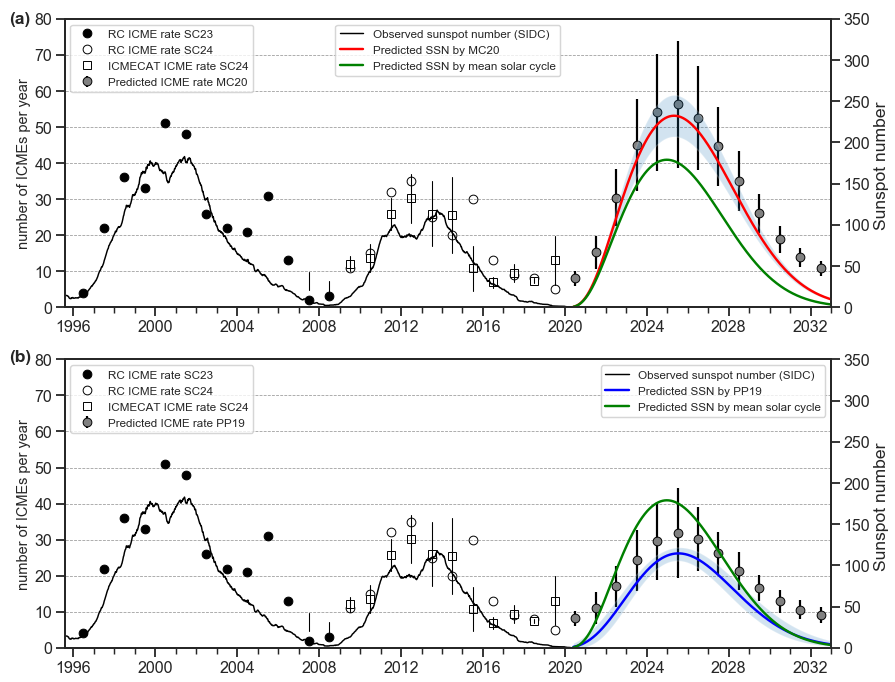

In [14]:
sns.set_context("talk")     
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(3,figsize=(13,10),dpi=70)

fsize=15
max_spot=350
max_icme=80

####################### MC20 model
ax1 = plt.subplot(211) 

################## ICR 
ax1.plot(yearly_mid_times_23,rc_rate23, color='black',marker='o',markerfacecolor='black',label='RC ICME rate SC23',linestyle='')
ax1.plot(yearly_mid_times_24,rc_rate24, color='black', marker='o',markerfacecolor='white',label='RC ICME rate SC24',linestyle='')
ax1.plot(yearly_mid_times_24,ic_rate24, color='black', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC24',linestyle='')
ax1.plot([mdates.num2date(icrate.year),mdates.num2date(icrate.year)],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=1.1,label='')

#ax1.plot(yearly_mid_times_25,icmes_predict_25mc,color='black', marker='o',markerfacecolor='grey',label='Predicted ICME rate MC20',linestyle='')
ax1.errorbar(yearly_mid_times_25,icmes_predict_25mc,yerr=ic_rate_25_mc20_std, color='black', marker='o',markerfacecolor='grey',label='Predicted ICME rate MC20',linestyle='')

ax1.set_ylim(0,max_icme)
ax1.set_ylabel('number of ICMEs per year',fontsize=fsize)
ax1.legend(loc=2,fontsize=12)


################## SSN
ax2=ax1.twinx()
ax2.plot(ssn.time,ssn.spot_mean_12,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC)')

ax2.plot(times_25_daily,spots_predict_25_daily,'-r',alpha=1,linewidth=2.5,label='Predicted SSN by MC20')
ax2.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Predicted SSN by mean solar cycle')
#ax2.fill_between(times_25_daily, spots_predict_25_daily_lower95, spots_predict_25_daily_upper95, alpha=0.2)
ax2.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.2)

ax2.set_ylabel('Sunspot number ')
ax2.set_xlim(parse_time('1995-Aug-01 00:00').plot_date,parse_time('2033-Jan-01 00:00').plot_date)
ax2.set_ylim(0,max_spot)
years = mdates.YearLocator()   # every year
ax2.xaxis.set_minor_locator(years)
ax2.legend(loc='upper center',fontsize=12)


############################################################## PP19 panel
ax3 = plt.subplot(212) 

##########ICR axis
ax3.plot(yearly_mid_times_23,rc_rate23, color='black',marker='o',markerfacecolor='black',label='RC ICME rate SC23',linestyle='')
ax3.plot(yearly_mid_times_24,rc_rate24, color='black', marker='o',markerfacecolor='white',label='RC ICME rate SC24',linestyle='')
ax3.plot(yearly_mid_times_24,ic_rate24, color='black', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC24',linestyle='')
ax3.plot([mdates.num2date(icrate.year),mdates.num2date(icrate.year)],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=1.1,label='')

#ax3.plot(yearly_mid_times_25,icmes_predict_25pp,color='black', marker='o',markerfacecolor='grey',label='Predicted ICME rate PP19',linestyle='')
ax3.errorbar(yearly_mid_times_25,icmes_predict_25pp,yerr=ic_rate_25_pp_std, color='black', marker='o',markerfacecolor='grey',label='Predicted ICME rate PP19',linestyle='')

ax3.set_ylim(0,max_icme)
ax3.set_ylabel('number of ICMEs per year',fontsize=fsize)
ax3.legend(loc=2,fontsize=12)

######SSN axis
ax4=ax3.twinx()
#observed SSN
ax4.plot(ssn.time,ssn.spot_mean_12,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC)')
#PP25 prediction
ax4.plot(times_25_daily,spots_predict_25pp_daily,'-b',alpha=1,linewidth=2.5,label='Predicted SSN by PP19')
ax4.fill_between(times_25_daily,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2)
#mean cycle
ax4.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Predicted SSN by mean solar cycle')
ax4.set_ylabel('Sunspot number ')
ax4.set_xlim(parse_time('1995-Aug-01 00:00').plot_date,parse_time('2033-Jan-01 00:00').plot_date)
ax4.set_ylim(0,max_spot)
years = mdates.YearLocator()   # every year
ax4.xaxis.set_minor_locator(years)
ax4.legend(loc=1,fontsize=12)

#grid on both panels
gridtime=[datetime.datetime(1995, 1,1), datetime.datetime(2035, 1, 1)]

for i in np.arange(0,100,10):
    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='k',alpha=0.4,lw=0.8)
for i in np.arange(0,100,10):
    ax3.plot(gridtime,[0,0]+i,linestyle='--',color='k',alpha=0.4,lw=0.8)

plt.tight_layout()

plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.47],xycoords='figure fraction',weight='bold')

plt.savefig('results/plots_rate/fig3_sc25_predictions.pdf', dpi=300)
plt.savefig('results/plots_rate/fig3_sc25_predictions.png', dpi=300)

get sunspot number from SIDC


time convert done


/Users/chris/anaconda3/envs/helio/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


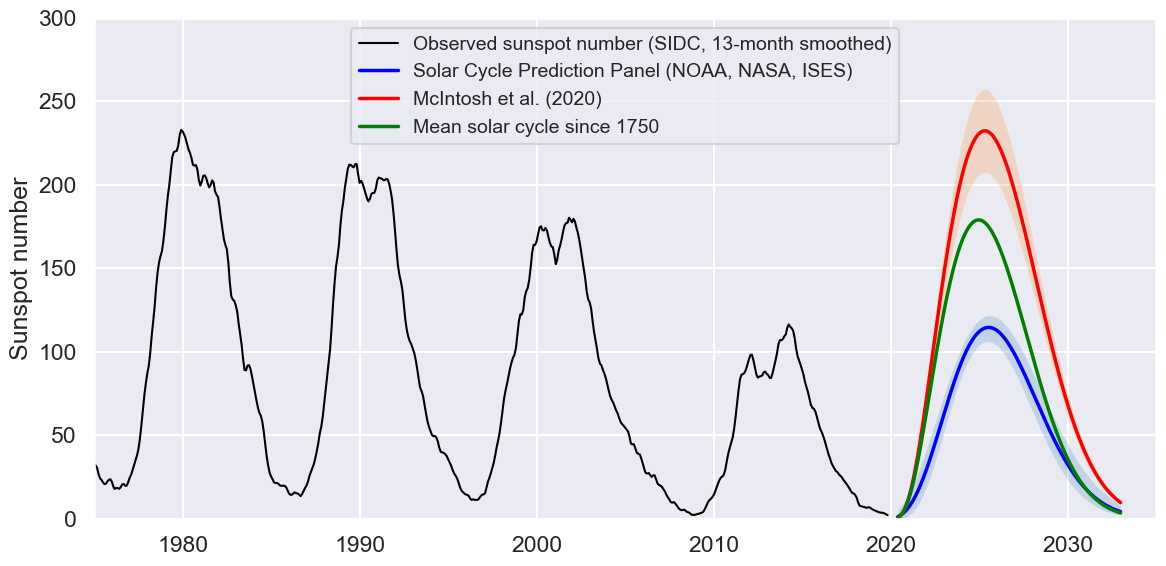

In [15]:
#Extra plot for solar cycle comparison
sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(3,figsize=(12,6),dpi=100)



##################
print('get sunspot number from SIDC')    
#get 13month smoothed sunspot number from SIDC
#http://www.sidc.be/silso/datafiles
#add year;month;year2;spot;stand;obs;check in first row to read pandas dataframe

get_new_sunspots_ms=1

if get_new_sunspots_ms==1:
    
    ssn_ms=pd.read_csv('data/SN_ms_tot_V2.0.csv',sep=';')
    ssn_ms_time=np.zeros(len(ssn_ms))
    
    for k in np.arange(len(ssn_ms)):
        ssn_ms_time[k]=parse_time(str(ssn_ms.year[k])+'-'+str(ssn_ms.month[k])+'-01').plot_date
        #print(mdates.num2date(ssn_ms_time[k]))
        #print(ssn_ms.spot[k])

    print('time convert done')
    ssn_ms.insert(0,'time',ssn_ms_time)
    ssn_ms.spot.loc[np.where(ssn_ms.spot< 0)[0]]=np.nan    
    
    fileout='ssn_13ms.p'
    pickle.dump(ssn_ms, open(data_path+fileout, "wb"))

file='ssn_13ms.p'  
ssn_ms=pickle.load(open(data_path+file, "rb"))

fsize=15
max_spot=300

ax1 = plt.subplot(111) 

ax1.plot(ssn_ms.time,ssn_ms.spot,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC, 13-month smoothed)')


#PP25 prediction
ax1.plot(times_25_daily,spots_predict_25pp_daily,'-b',alpha=1,linewidth=2.5,label='Solar Cycle Prediction Panel (NOAA, NASA, ISES)')
ax1.fill_between(times_25_daily,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2)

ax1.plot(times_25_daily,spots_predict_25_daily,'-r',alpha=1,linewidth=2.5,label='McIntosh et al. (2020)')
ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.2)

#mean cycle
ax1.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Mean solar cycle since 1750')

ax1.set_xlim(datetime.datetime(1749,1,1),datetime.datetime(2035,1,1))

ax1.set_ylim(0,max_spot)
ax1.set_ylabel('Sunspot number')

plt.legend(loc='upper center',fontsize=10)
plt.tight_layout()



plt.savefig('results/cycle25_prediction.png',dpi=100)

#with shorter interval
plt.legend(loc='upper center',fontsize=14)
ax1.set_xlim(datetime.datetime(1975,1,1),datetime.datetime(2035,1,1))
plt.savefig('results/cycle25_prediction_short.png',dpi=100)


# 4 Parker Probe ICME rate prediction

### make PSP and Solar Orbiter position

PSP pos



Solo pos


Bepi done


mercury


Text(0.5, 0, 'AU')

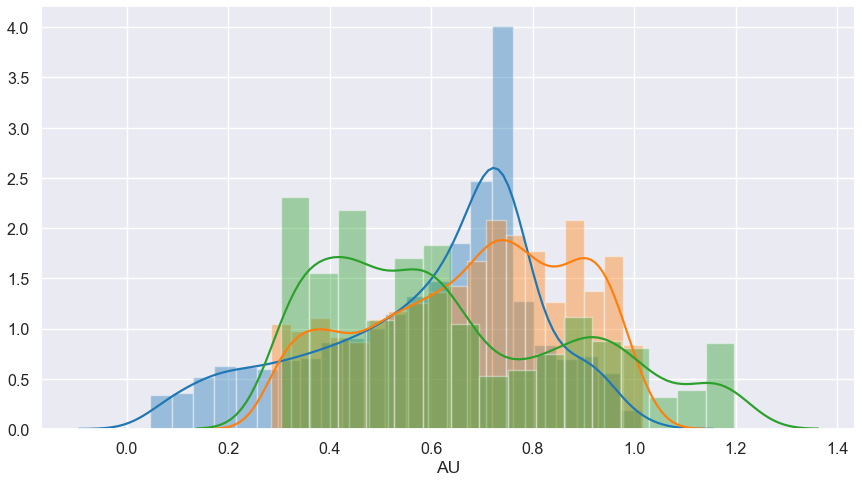

In [16]:
frame='HEEQ'
starttime =datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time = []
res_in_days=1
while starttime < endtime:
    pspt_time.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_num=parse_time(pspt_time).plot_date
starttime =datetime.datetime(2018, 8,13)

spice.furnish(spicedata.get_kernel('psp_pred'))
pspt=spice.Trajectory('SPP')
pspt.generate_positions(pspt_time,'Sun',frame)
psp_speed=pspt.speed.value
pspt.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=hd.cart2sphere(pspt.x,pspt.y,pspt.z)
print('PSP pos')
print()

frame='HEEQ'
starttime =datetime.datetime(2020, 3,1)
endtime = datetime.datetime(2030, 9, 1)
solot_time = []
res_in_days=1
while starttime < endtime:
    solot_time.append(starttime)
    starttime += timedelta(days=res_in_days)
solot_time_num=parse_time(solot_time).plot_date     
starttime =datetime.datetime(2020, 3,1)

spice.furnish(spicedata.get_kernel('solo_2020'))
solot=spice.Trajectory('Solar Orbiter')
solot.generate_positions(solot_time,'Sun',frame)
solot.change_units(astropy.units.AU)  
[solo_r, solo_lat, solo_lon]=hd.cart2sphere(solot.x,solot.y,solot.z)
print('Solo pos')


############################################## BepiColombo

starttime =datetime.datetime(2018, 10, 21)
endtime = datetime.datetime(2025, 11, 2)
bepi_time = []
while starttime < endtime:
    bepi_time.append(starttime)
    starttime += timedelta(days=res_in_days)

spice.furnish(spicedata.get_kernel('bepi_pred'))
bepi=spice.Trajectory('BEPICOLOMBO MPO') # or BEPICOLOMBO MMO
bepi.generate_positions(bepi_time,'Sun',frame)
bepi.change_units(astropy.units.AU)  
[bepi_r, bepi_lat, bepi_lon]=hd.cart2sphere(bepi.x,bepi.y,bepi.z)

print('Bepi done')


#add mercury
planet_kernel=spicedata.get_kernel('planet_trajectories')
starttime= datetime.datetime(2025, 11, 3)
endtime = datetime.datetime(2032, 12, 31)
mercury_time = []
while starttime < endtime:
    mercury_time.append(starttime)
    starttime += timedelta(days=res_in_days)

mercury=spice.Trajectory('1')  #barycenter
mercury.generate_positions(mercury_time,'Sun',frame)  
mercury.change_units(astropy.units.AU)  
[mercury_r, mercury_lat, mercury_lon]=hd.cart2sphere(mercury.x,mercury.y,mercury.z)
print('mercury') 

#combine bepi trajectory with Mercury
bepi_time2=np.hstack([bepi_time,mercury_time])
bepi_r2=np.hstack([bepi_r,mercury_r])




sns.set_style('darkgrid')
plt.figure(21,dpi=70)
sns.distplot(psp_r)
sns.distplot(solo_r)
sns.distplot(bepi_r)
plt.xlabel('AU')

psp maximum speed  189.40565042481333  km/s at  0.04589802143421681  AU


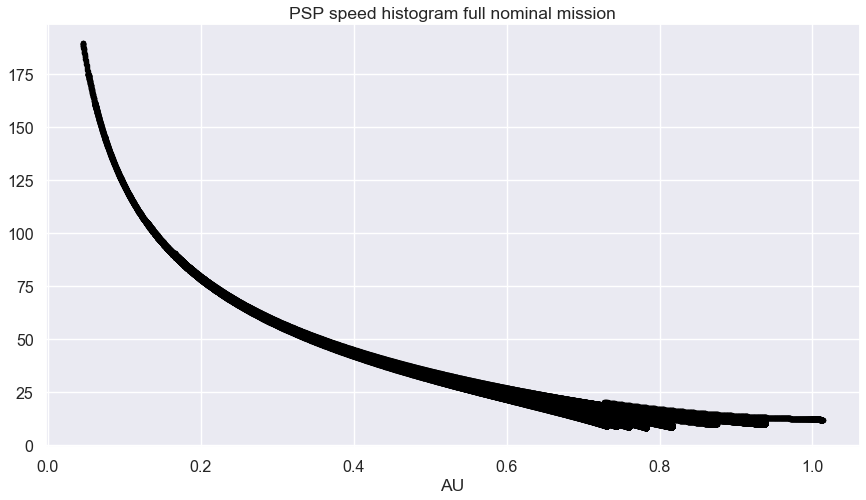

In [17]:
#get the speed in hourly resolution

frame='HEEQ'
starttime =datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time_highres = []
res_in_days=1/24.
while starttime < endtime:
    pspt_time_highres.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_highres_num=parse_time(pspt_time_highres).plot_date
starttime =datetime.datetime(2018, 8,13)

pspt_highres=spice.Trajectory('SPP')
pspt_highres.generate_positions(pspt_time_highres,'Sun',frame)
psp_highres_speed=pspt_highres.speed.value
pspt_highres.change_units(astropy.units.AU)  
[psp_highres_r, psp_highres_lat, psp_highres_lon]=hd.cart2sphere(pspt_highres.x,pspt_highres.y,pspt_highres.z)

plt.figure(22,dpi=70)
plt.title('PSP speed histogram full nominal mission')
plt.plot(psp_highres_r,psp_highres_speed,'.k')
plt.xlabel('AU')

print('psp maximum speed ',np.max(psp_highres_speed),' km/s at ',psp_highres_r[np.argmax(psp_highres_speed)], ' AU')

In [18]:
#%matplotlib inline

sns.set_context('talk')


sns.set_style('whitegrid')

fig=plt.figure(23,figsize=(13,10),dpi=70)

ax1 = plt.subplot(211) 
ax1.plot_date(pspt_time_highres_num,psp_highres_r,c='r',linestyle='-',markersize=0)

ax1.set_ylim(0,0.95)
ax1.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax1.yaxis.set_ticks(np.arange(0,1,0.1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.tick_params(which="both", bottom=True)
plt.ylabel('PSP distance [AU]')
ax1.grid(which='major',linestyle='--',alpha=0.7)
#ax1.set_zorder(3)

plt.title('Parker Solar Probe trajectory')

#grid
#gridtime=[datetime.datetime(2018, 1,1), datetime.datetime(2026, 1, 1)]
#for i in np.arange(0,1,0.1):
#    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='grey',alpha=0.7,lw=0.8)


    
ax2=ax1.twinx()
ax2.plot_date(pspt_time_highres_num,215.03*psp_highres_r,c='r',linestyle='-',markersize=0)
ax2.set_ylabel('solar radii')
ax2.set_ylim(0,0.95*215.03)
ax2.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax2.yaxis.set_ticks(np.arange(0,220,20))
ax2.grid(b=None)


sns.set_style('whitegrid')
ax3 = plt.subplot(212) 
ax3.plot_date(pspt_time_highres_num,psp_highres_speed,'-r',zorder=3)
plt.ylabel('PSP speed [km/s]')
#plt.xlabel('year')
ax3.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax3.set_ylim(0,210)
ax3.xaxis.set_minor_locator(mdates.MonthLocator())
ax3.tick_params(which="both", bottom=True)
ax3.grid(which='major',linestyle='--',alpha=0.7)

#find perihelia and aphelia
dr=np.gradient(psp_highres_r)
dr_minmax=np.where(np.diff(np.sign(dr)))[0]
for i in np.arange(0,48,2):
    ax1.text(pspt_time_highres_num[dr_minmax[i]],psp_highres_r[dr_minmax[i]]-0.038,str(int(i/2)+1),fontsize=13,zorder=0,horizontalalignment='center')



#find perihelia and aphelia
for i in np.arange(0,48,2):
    ax3.text(pspt_time_highres_num[dr_minmax[i]],psp_highres_speed[dr_minmax[i]]+5,str(int(i/2)+1),fontsize=13,horizontalalignment='center')

plt.tight_layout()
plt.figtext(0.99,0.008,'C. Möstl @chrisoutofspace', fontsize=10, ha='right',color='k',style='italic')     


plt.savefig('results/psp_orbits.png', dpi=100)

solo maximum speed  60.739231557446864  km/s at  0.2842351199095981  AU


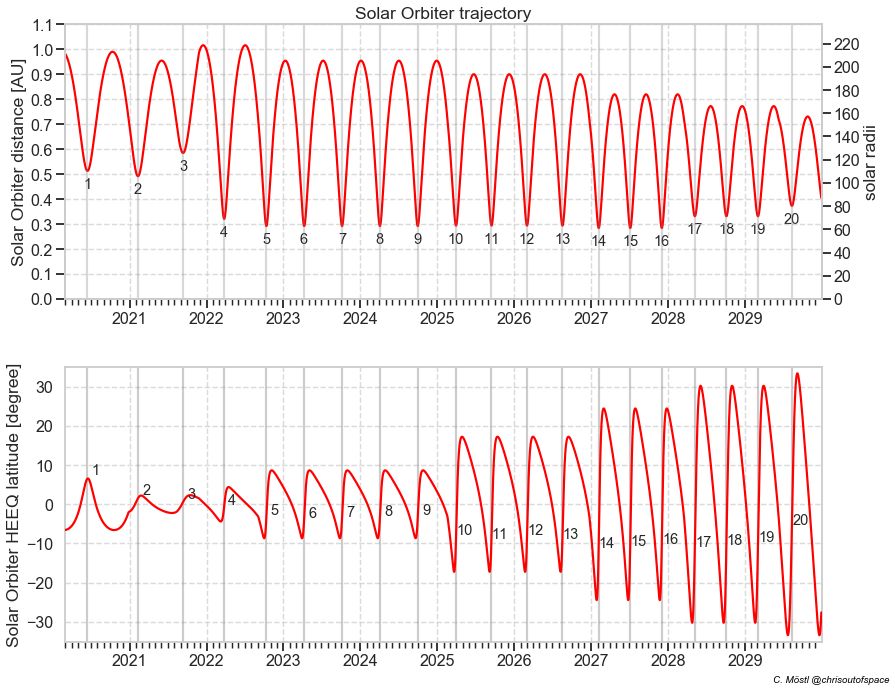

In [74]:
#same thing for Solar Orbiter

frame='HEEQ'
starttime =datetime.datetime(2020, 3,1)
endtime = datetime.datetime(2029, 12, 31)
solo_time_highres = []
res_in_days=1.
while starttime < endtime:
    solo_time_highres.append(starttime)
    starttime += timedelta(days=res_in_days)
solo_time_highres_num=parse_time(solo_time_highres).plot_date
starttime =datetime.datetime(2020, 3,1)

solo_highres=spice.Trajectory('Solar Orbiter')
solo_highres.generate_positions(solo_time_highres,'Sun',frame)
solo_highres_speed=solo_highres.speed.value
solo_highres.change_units(astropy.units.AU)  
[solo_highres_r, solo_highres_lat, solo_highres_lon]=hd.cart2sphere(solo_highres.x,solo_highres.y,solo_highres.z)

solo_highres_lat=np.degrees(solo_highres_lat)
solo_highres_lon=np.degrees(solo_highres_lon)
print('solo maximum speed ',np.max(solo_highres_speed),' km/s at ',solo_highres_r[np.argmax(solo_highres_speed)], ' AU')


#%matplotlib inline

sns.set_context('talk')
sns.set_style('whitegrid')

fig=plt.figure(23,figsize=(13,10),dpi=70)

ax1 = plt.subplot(211) 
ax1.plot_date(solo_time_highres_num,solo_highres_r,c='r',linestyle='-',markersize=0)

ax1.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))

ax1.yaxis.set_ticks(np.arange(0,1.3,0.1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.tick_params(which="both", bottom=True)
plt.ylabel('Solar Orbiter distance [AU]')
ax1.grid(which='major',linestyle='--',alpha=0.7)
#ax1.set_zorder(3)

ax1.set_ylim(0,1.1)


plt.title('Solar Orbiter trajectory')

#grid
#gridtime=[datetime.datetime(2018, 1,1), datetime.datetime(2026, 1, 1)]
#for i in np.arange(0,1,0.1):
#    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='grey',alpha=0.7,lw=0.8)

    
ax2=ax1.twinx()
ax2.plot_date(solo_time_highres_num,215.03*solo_highres_r,c='r',linestyle='',markersize=0)
ax2.set_ylabel('solar radii')
ax2.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))
ax2.yaxis.set_ticks(np.arange(0,260,20))
ax2.grid(b=None)
ax2.set_ylim(0,1.1*215.03)



sns.set_style('whitegrid')
ax3 = plt.subplot(212) 
ax3.plot_date(solo_time_highres_num,solo_highres_lat,'-r',zorder=3)
plt.ylabel('Solar Orbiter HEEQ latitude [degree]')
#plt.xlabel('year')
ax3.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))

ax3.set_ylim(-35,35)
ax3.xaxis.set_minor_locator(mdates.MonthLocator())
ax3.tick_params(which="both", bottom=True)
ax3.grid(which='major',linestyle='--',alpha=0.7)

#find perihelia and aphelia
dr=np.gradient(solo_highres_r)
dr_minmax=np.where(np.diff(np.sign(dr)))[0]

#plot numbers
for i in np.arange(0,39,2):
    ax1.text(solo_time_highres_num[dr_minmax[i]],solo_highres_r[dr_minmax[i]]-0.07,str(int(i/2)+1),fontsize=15,zorder=0,horizontalalignment='center')
    
    ax1.plot([solo_time_highres_num[dr_minmax[i]],solo_time_highres_num[dr_minmax[i]]],[-50,50],linestyle='-', color='grey',alpha=0.3)


    ax3.text(solo_time_highres_num[dr_minmax[i]]+40,solo_highres_lat[dr_minmax[i]]+1,str(int(i/2)+1),fontsize=15,horizontalalignment='center')    
    ax3.plot([solo_time_highres_num[dr_minmax[i]],solo_time_highres_num[dr_minmax[i]]],[-50,50],linestyle='-', color='grey',alpha=0.4)

plt.tight_layout()
plt.figtext(0.99,0.008,'C. Möstl @chrisoutofspace', fontsize=10, ha='right',color='k',style='italic')     


plt.savefig('results/solo_orbits.png', dpi=100)

### Calculate expected number of PSP ICMEs < 0.3, 0.2, 0.1 AU 

first calculate smooth functions for the icme rate including the derived error bars in Figure 3

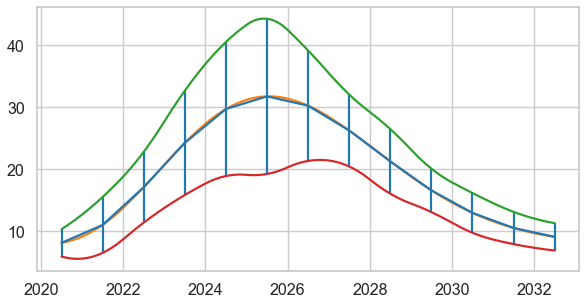

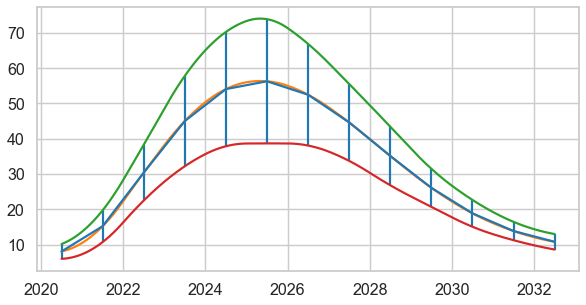

In [19]:
#fit yearly ICME rates again with hathaway function to get to daily resolution including errors


#define times a bit differently
yearly_mid_times_25_num=mdates.date2num(yearly_mid_times_25)
times_25_daily_icrange= [ yearly_mid_times_25[0] + datetime.timedelta(days=n) for n in range(int ((yearly_mid_times_25[-1] - yearly_mid_times_25[0]).days))]  
times_25_daily_icrange_num=mdates.date2num(times_25_daily_icrange)


##PP19 model

#yearly_mid_times_25,icmes_predict_25pp,yerr=ic_rate_25_pp_std, 
plt.figure(51,figsize=(10,5),dpi=70)
plt.errorbar(yearly_mid_times_25,icmes_predict_25pp,yerr=ic_rate_25_pp_std)

icratepp_low=icmes_predict_25pp-ic_rate_25_pp_std
icratepp_high=icmes_predict_25pp+ic_rate_25_pp_std
#plt.plot(yearly_mid_times_25,icratepp_low)
#plt.plot(yearly_mid_times_25,icratepp_high)

#smooth with spline
from scipy.interpolate import interp1d
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

fpp = interp1d(yearly_mid_times_25_num, icmes_predict_25pp, kind=2)
fpp_high = interp1d(yearly_mid_times_25_num, icratepp_high, kind=2)
fpp_low = interp1d(yearly_mid_times_25_num, icratepp_low, kind=2)

plt.plot(times_25_daily_icrange_num,fpp(times_25_daily_icrange_num))
plt.plot(times_25_daily_icrange_num,fpp_high(times_25_daily_icrange_num))
plt.plot(times_25_daily_icrange_num,fpp_low(times_25_daily_icrange_num))



#MC20 model
plt.figure(52,figsize=(10,5),dpi=70)


#yearly_mid_times_25,icmes_predict_25mc,yerr=ic_rate_25_mc20_std,
plt.errorbar(yearly_mid_times_25,icmes_predict_25mc,yerr=ic_rate_25_mc20_std)

icratemc_low=icmes_predict_25mc-ic_rate_25_mc20_std
icratemc_high=icmes_predict_25mc+ic_rate_25_mc20_std
#plt.plot(yearly_mid_times_25,icratemc_low)
#plt.plot(yearly_mid_times_25,icratemc_high)

fmc = interp1d(yearly_mid_times_25_num, icmes_predict_25mc, kind=2)
fmc_high = interp1d(yearly_mid_times_25_num, icratemc_high, kind=2)
fmc_low = interp1d(yearly_mid_times_25_num, icratemc_low, kind=2)

plt.plot(times_25_daily_icrange_num,fmc(times_25_daily_icrange_num))
plt.plot(times_25_daily_icrange_num,fmc_high(times_25_daily_icrange_num))
plt.plot(times_25_daily_icrange_num,fmc_low(times_25_daily_icrange_num))

Figure out how many ICMEs PSP sees < 0.1 AU, < 0.2 AU, < 0.3 AU for the predicted ICME rates

In [20]:
#make position new in order to be of similar range with ICME rate spline fits
frame='HEEQ'
starttime =times_25_daily_icrange[0]
endtime = datetime.datetime(2025, 8, 31)
pspt_time = []
res_in_days=1
while starttime < endtime:
    pspt_time.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_num=parse_time(pspt_time).plot_date

spice.furnish(spicedata.get_kernel('psp_pred'))
pspt=spice.Trajectory('SPP')
pspt.generate_positions(pspt_time,'Sun',frame)
pspt.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=hd.cart2sphere(pspt.x,pspt.y,pspt.z)
print('PSP pos')
print()

#all positions
psp_l10=np.where(psp_r < 1.0)[0]
#positions less 0.3 AU
psp_l03=np.where(psp_r < 0.3)[0]
#positions less 0.2 AU
psp_l02=np.where(psp_r < 0.2)[0]
#positions less 0.1 AU
psp_l01=np.where(psp_r < 0.1)[0]



print('!!!!!! all results below calculated from 2020 July 1 !!!!!!!!!!!!!')
print('PSP spends ... ')
print('days < 0.3 AU:',psp_l03.size)
print('days < 0.2 AU:',psp_l02.size)
print('days < 0.1 AU:',psp_l01.size)

# pspt_time_num[psp_l03]
# psp_r[psp_l03]
# times_25_daily_num=mdates.date2num(times_25_daily) 
# ic25=icmes_predict_25mc_daily/365.24


#################### Calculate PSP ICME rate

#MC20
print('---------------')
print('MC20 prediction')
print('using spline fits to get from yearly to daily ICME rates including error bars')

#old version with hathawy function for SSN and conversion instead of spline (result similar for average, but errors not good)
#spots_predict_25_daily_mc_psp=hs.hathaway(pspt_time, start_25-shift_t0,a,b,c)
#icmes_psp_predict_mc_daily=ssn_to_rate(spots_predict_25_daily_mc_psp,linfit)[0]/365.24

icmes_psp_predict_mc_daily=fmc(times_25_daily_icrange_num)/365.24
icmes_psp_predict_mc_daily_low=fmc_low(times_25_daily_icrange_num)/365.24
icmes_psp_predict_mc_daily_high=fmc_high(times_25_daily_icrange_num)/365.24

print('ICME events in situ at PSP total mission : ', int(np.rint(np.sum(icmes_psp_predict_mc_daily[psp_l10]))))
print('ICME events in situ at PSP < 0.3 AU: ', int(np.rint(np.sum(icmes_psp_predict_mc_daily[psp_l03]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_low[psp_l03]))),' / ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_high[psp_l03]))))
print('ICME events in situ at PSP < 0.2 AU: ', int(np.rint(np.sum(icmes_psp_predict_mc_daily[psp_l02]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_low[psp_l02]))),' / ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_high[psp_l02]))))
print('ICME events in situ at PSP < 0.1 AU: ', int(np.rint(np.sum(icmes_psp_predict_mc_daily[psp_l01]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_low[psp_l01]))),' / ',int(np.rint(np.sum(icmes_psp_predict_mc_daily_high[psp_l01]))))


#check if correct
# plt.plot(pspt_time_num,psp_r)
# plt.plot_date(pspt_time_num[psp_l03],icmes_psp_predict_mc_daily[psp_l03],'ob')
# plt.plot_date(pspt_time_num[psp_l02],icmes_psp_predict_mc_daily[psp_l02],'ok')
# plt.plot_date(pspt_time_num[psp_l01],icmes_psp_predict_mc_daily[psp_l01],'or')




print('---------------')
print('PP19 prediction')

#old version with Hathway fit
#PP19 get SSN from Hathaway model
#spots_predict_25_daily_pp_psp=hs.hathaway(pspt_time, start_25_fit,app,bpp,cpp)
#get ICR from SSN                     
#icmes_psp_predict_pp_daily=ssn_to_rate(spots_predict_25_daily_pp_psp,linfit)[0]/365.24


#new version with spline fits
icmes_psp_predict_pp_daily=fpp(times_25_daily_icrange_num)/365.24
icmes_psp_predict_pp_daily_low=fpp_low(times_25_daily_icrange_num)/365.24
icmes_psp_predict_pp_daily_high=fpp_high(times_25_daily_icrange_num)/365.24



# plt.plot_date(pspt_time_num[psp_l03],icmes_psp_predict_pp_daily[psp_l03],'sb')
# plt.plot_date(pspt_time_num[psp_l02],icmes_psp_predict_pp_daily[psp_l02],'sk')
# plt.plot_date(pspt_time_num[psp_l01],icmes_psp_predict_pp_daily[psp_l01],'sr')

print('ICME events in situ at PSP total mission : ', int(np.rint(np.sum(icmes_psp_predict_pp_daily[psp_l10]))))
print('ICME events in situ at PSP < 0.3 AU: ', int(np.rint(np.sum(icmes_psp_predict_pp_daily[psp_l03]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_low[psp_l03]))),' / ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_high[psp_l03]))))
print('ICME events in situ at PSP < 0.2 AU: ', int(np.rint(np.sum(icmes_psp_predict_pp_daily[psp_l02]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_low[psp_l02]))),' / ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_high[psp_l02]))))
print('ICME events in situ at PSP < 0.1 AU: ', int(np.rint(np.sum(icmes_psp_predict_pp_daily[psp_l01]))))
print('range low/high: ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_low[psp_l01]))),' / ',int(np.rint(np.sum(icmes_psp_predict_pp_daily_high[psp_l01]))))




#---------------------------------------------------- Solar Orbiter

solo_l05=np.where(solo_r < 0.5)[0]
solo_l04=np.where(solo_r < 0.4)[0]
solo_l03=np.where(solo_r < 0.3)[0]

print()
print()
print('-----------------------')
print('SolO spends ... ')
print('days < 0.5 AU:',solo_l05.size)
print('days < 0.4 AU:',solo_l04.size)
print('days < 0.3 AU:',solo_l03.size)

PSP pos

!!!!!! all results below calculated from 2020 July 1 !!!!!!!!!!!!!
PSP spends ... 
days < 0.3 AU: 255
days < 0.2 AU: 142
days < 0.1 AU: 48
---------------
MC20 prediction
using spline fits to get from yearly to daily ICME rates including error bars
ICME events in situ at PSP total mission :  186
ICME events in situ at PSP < 0.3 AU:  26
range low/high:  18  /  33
ICME events in situ at PSP < 0.2 AU:  14
range low/high:  10  /  18
ICME events in situ at PSP < 0.1 AU:  5
range low/high:  4  /  7
---------------
PP19 prediction
ICME events in situ at PSP total mission :  107
ICME events in situ at PSP < 0.3 AU:  15
range low/high:  9  /  20
ICME events in situ at PSP < 0.2 AU:  8
range low/high:  5  /  11
ICME events in situ at PSP < 0.1 AU:  3
range low/high:  2  /  4


-----------------------
SolO spends ... 
days < 0.5 AU: 818
days < 0.4 AU: 463
days < 0.3 AU: 77


## **Figure 4** PSP Solar Orbiter distance and ICME rate

/Users/chris/anaconda3/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempting to set identical left == right == 739494.0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app
/Users/chris/anaconda3/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Attempting to set identical left == right == 739494.0 results in singular transformations; automatically expanding.


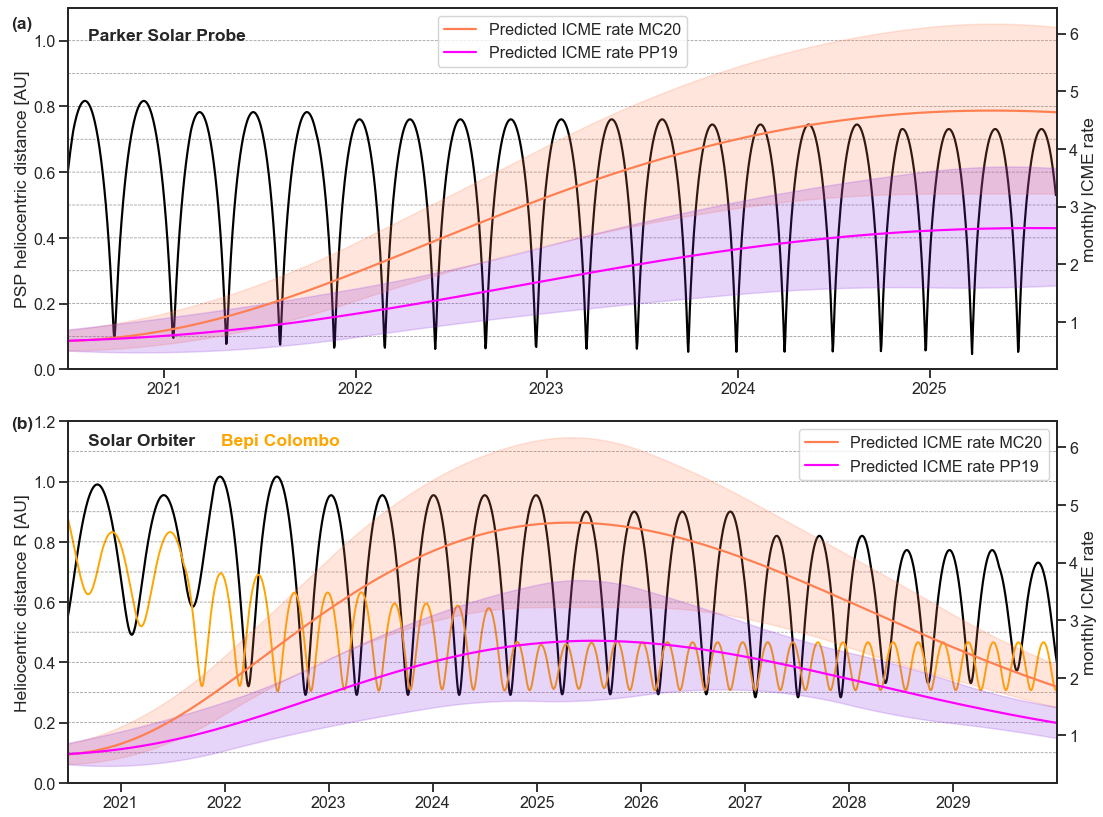

In [21]:
sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style("ticks")
fsize=15

fig=plt.figure(4,figsize=(16,12),dpi=70)
ax1 = plt.subplot(211) 
#plot R[AU]
ax1.plot_date(pspt_time,psp_r,'-k')
#grid
for i in np.arange(0.1,1.2,0.1):
    ax1.plot(pspt_time,np.zeros(len(psp_r))+i,linestyle='--',color='k',alpha=0.4,lw=0.8)

ax1.set_ylabel('PSP heliocentric distance [AU]')
ax1.set_xlim(starttime,endtime)
ax1.set_ylim(0,1.1)

#p######################## plot ICR
ax2=ax1.twinx()

#ax2.plot(yearly_mid_times_25,icmes_predict_25/365.24, marker='s',markerfacecolor='coral', alpha=0.9,label='Predicted ICME rate MC20',linestyle='')
ax2.plot(times_25_daily,icmes_predict_25mc_daily*30.25/365.24, color='coral', label='Predicted ICME rate MC20',linestyle='-')
ax2.plot(times_25_daily,icmes_predict_25pp_daily*30.25/365.24, color='magenta', label='Predicted ICME rate PP19',linestyle='-')

#error bars - 30.42/364.24 converts the yearly rate from the spline function to monthly rates like 3 lines above
#ax2.plot(times_25_daily_icrange_num,fmc_low(times_25_daily_icrange_num)*30.42/365.24,color='coral',linestyle='--')
#ax2.plot(times_25_daily_icrange_num,fmc_high(times_25_daily_icrange_num)*30.42/365.24,color='coral',linestyle='--')
ax2.fill_between(times_25_daily_icrange_num, fmc_low(times_25_daily_icrange_num)*30.42/365.248, fmc_high(times_25_daily_icrange_num)*30.42/365.24, alpha=0.2,color='coral')

#same for pp model
#ax2.plot(times_25_daily_icrange_num,fpp_low(times_25_daily_icrange_num)*30.42/365.24,color='magenta',linestyle='--')
#ax2.plot(times_25_daily_icrange_num,fpp_high(times_25_daily_icrange_num)*30.42/365.24,color='magenta',linestyle='--')
ax2.fill_between(times_25_daily_icrange_num, fpp_low(times_25_daily_icrange_num)*30.42/365.248, fpp_high(times_25_daily_icrange_num)*30.42/365.24, alpha=0.2,color='blueviolet')

ax2.set_ylabel('monthly ICME rate')
plt.legend(loc='upper center')

plotstart=datetime.datetime(2020, 7, 1)
plotend=datetime.datetime(2025, 9,1)
plt.xlim(plotstart,plotend)


################ Solar Orbiter
ax3 = plt.subplot(212) 
ax3.plot_date(solot_time,solo_r,'-k')
ax3.plot_date(bepi_time2,bepi_r2,linestyle='-',color='orange',lw=2,markersize=0)


#ax3.plot_date(solot_time,np.degrees(solo_lat)/100,'--k')
#ax3.plot(solot_time,np.zeros(len(solo_r))+0.5,linestyle='--',color='b',alpha=.6)
#ax3.plot(solot_time,np.zeros(len(solo_r))+0.4,linestyle='--',color='b',alpha=.6)
#ax3.plot(solot_time,np.zeros(len(solo_r))+0.3,linestyle='--',color='b',alpha=.6)

ax3.set_ylabel('Heliocentric distance R [AU]')
ax3.set_xlim(starttime,endtime)

for i in np.arange(0.1,1.2,0.1):
    ax3.plot(solot_time,np.zeros(len(solo_r))+i,linestyle='--',color='k',alpha=0.4,lw=0.8)

ax3.set_ylim(0,1.2)

#p######################## plot ICR
ax4=ax3.twinx()

#ax2.plot(yearly_mid_times_25,icmes_predict_25/365.24, marker='s',markerfacecolor='coral', alpha=0.9,label='Predicted ICME rate MC20',linestyle='')
ax4.plot(times_25_daily,icmes_predict_25mc_daily*30.42/365.24, color='coral', label='Predicted ICME rate MC20',linestyle='-')
ax4.plot(times_25_daily,icmes_predict_25pp_daily*30.42/365.24, color='magenta', label='Predicted ICME rate PP19',linestyle='-')

#error ranges
ax4.fill_between(times_25_daily_icrange_num, fmc_low(times_25_daily_icrange_num)*30.42/365.248, fmc_high(times_25_daily_icrange_num)*30.42/365.24, alpha=0.2,color='coral')
ax4.fill_between(times_25_daily_icrange_num, fpp_low(times_25_daily_icrange_num)*30.42/365.248, fpp_high(times_25_daily_icrange_num)*30.42/365.24, alpha=0.2,color='blueviolet')
ax4.set_ylabel('monthly ICME rate')
plt.legend(loc=1)

plotstart=datetime.datetime(2020, 7, 1)
plotend=datetime.datetime(2029, 12,31)
plt.xlim(plotstart,plotend)

plt.tight_layout()


plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold')
plt.annotate('Parker Solar Probe',[0.08,0.95],xycoords='figure fraction',weight='bold')
plt.annotate('Solar Orbiter',[0.08,0.455],xycoords='figure fraction',weight='bold')
plt.annotate('Bepi Colombo',[0.20,0.455],xycoords='figure fraction',weight='bold',color='orange')

plt.savefig('results/plots_rate/fig4_psp_rate.pdf', dpi=300)
plt.savefig('results/plots_rate/fig4_psp_rate.png', dpi=300)

# 5 3DCORE modeling of PSP double crossings

Here 3DCORE is used to model synthetic observations of expanding flux ropes close to the Sun

In [22]:
#!pip install 3DCORE if not already in the environment
import py3dcore
import heliosat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

############### Model Settings
t_launch = datetime.datetime(2022, 6, 1, 20)

iparams_arr = np.array([[
    0,      # time offset
    145,    # l_1 (logitude)
    2.5,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    600,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=3)
TP_B =  t_launch + datetime.timedelta(hours=28)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"



class PSP_FIXED(heliosat.PSP):
    def __init__(self, t_fixed, **kwargs):
        self.t_fixed = t_fixed

        super(PSP_FIXED, self).__init__(**kwargs)

    def trajectory(self, t, frame, **kwargs):
        return super().trajectory(t=[self.t_fixed] * len(t), frame=frame, **kwargs)

setattr(heliosat, "PSP_FIXED", PSP_FIXED)

In [23]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b

def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

def plot_3dcore_field(ax, obj, steps=500, step_size=0.005, **kwargs):
    q0 = kwargs.get("q0", np.array([1, .1, np.pi/2], dtype=np.float32)).astype(np.float32)

    fl = obj.visualize_fieldline(q0, steps=steps, step_size=step_size)

    ax.plot(*fl.T, **kwargs)

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)



## **Figure 5**


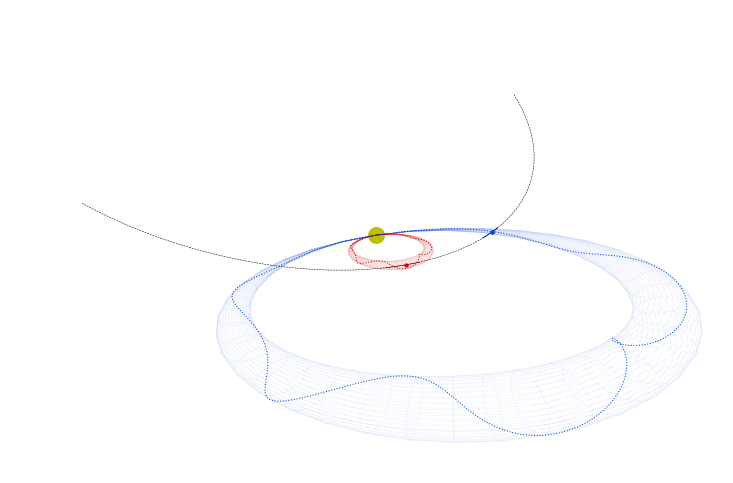

In [24]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 10),dpi=50)

ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=125, view_elev=40, view_radius=.15)
#plot_configure(ax, view_azim=125, view_elev=35, view_radius=.04)



plot_3dcore(ax, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax, model_obj, color=C_B, steps=1200, step_size=0.001, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()

plt.savefig('results/plots_rate/fig5_3dcore_visual.pdf', dpi=300)
plt.savefig('results/plots_rate/fig5_3dcore_visual.png', dpi=300)


In [25]:
t1, btot1, bxyz1 = measure(model_obj, "PSP", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN")
t2, btot2, bxyz2 = measure(model_obj, "PSP", TP_B - datetime.timedelta(hours=12), TP_B  + datetime.timedelta(hours=12), frame="ECLIPJ2000", bframe="SPP_RTN")

tf, btotf, bxyzf = measure(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN", satparams=TP_A)

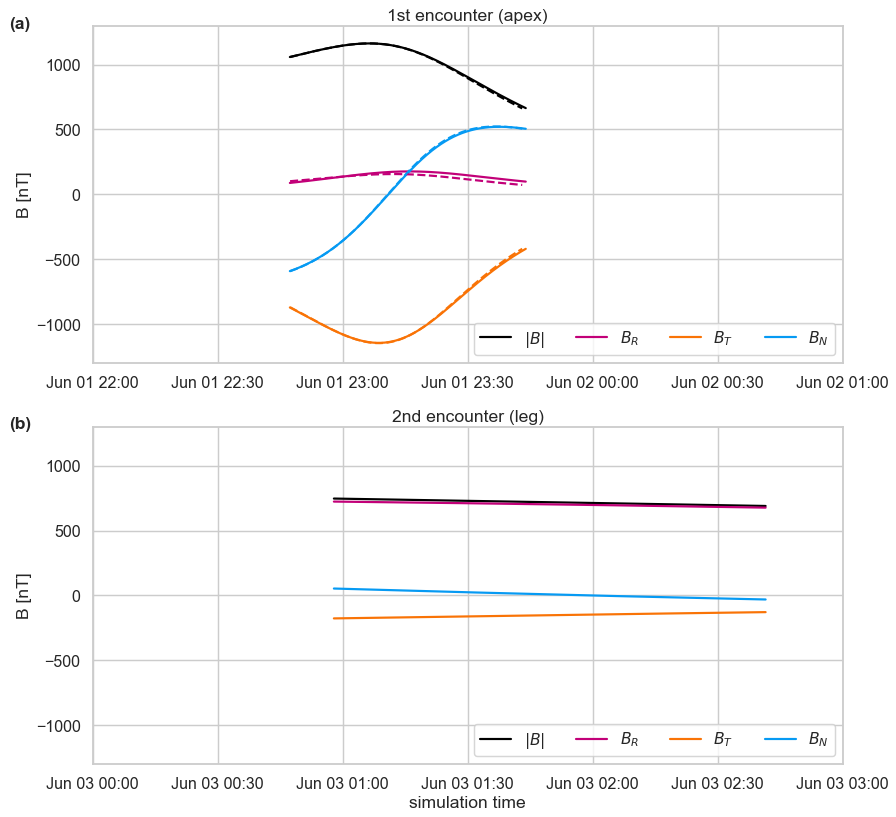

In [26]:
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(13, 12),dpi=70)

ax1 = fig.add_subplot(211)
ax1.set_title("1st encounter (apex)")

ax1.plot(t1, btot1, color=C0, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

ax1.plot(tf, btotf, color=C0, linestyle='--')
ax1.plot(tf, bxyzf[:, 0], color=C1, linestyle='--')
ax1.plot(tf, bxyzf[:, 1], color=C2, linestyle='--')
ax1.plot(tf, bxyzf[:, 2], color=C3, linestyle='--')

ax1.legend(loc="lower right", fontsize=16,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax1.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,1,22,0),datetime.datetime(2022,6,2,1,0))



ax2 = fig.add_subplot(212)
ax2.set_title("2nd encounter (leg)")

ax2.plot(t2, btot2, color=C0, label="$|B|$")
ax2.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax2.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax2.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")

ax2.legend(loc="lower right", fontsize=16,ncol=4)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax2.set_xlabel('simulation time')
ax2.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,3,0,0),datetime.datetime(2022,6,3,3,0))


plt.tight_layout()


plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold')

plt.savefig('results/plots_rate/fig6_3dcore_components.pdf', dpi=300)
plt.savefig('results/plots_rate/fig6_3dcore_components.png', dpi=300)

In [27]:
def plot_reconstruction(ax, obj, qs, **kwargs):

    ss = []

    for i in range(len(qs)):
        q = np.array([qs[i]])
        s = np.empty_like(q)

        obj.transform_qs(s, q)

        ss.append(s[0])

    ss = np.array(ss)

    ax.plot(*ss.T, **kwargs)

def reconstruct_path(obj, sat, t0, t1, frame="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    qs = []

    for i in range(len(t_s)):
        s = np.array([o_s[i]])
        q = np.empty_like(s)

        obj.propagate(t_s[i])
        obj.transform_sq(s, q)

        if q[0][0] < 1.0:
            qs.append(np.copy(q[0]))

    return qs

In [28]:
QPATH_PSP = reconstruct_path(model_obj, "PSP", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000")
QPATH_PSP_FIXED = reconstruct_path(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000", satparams=TP_A)

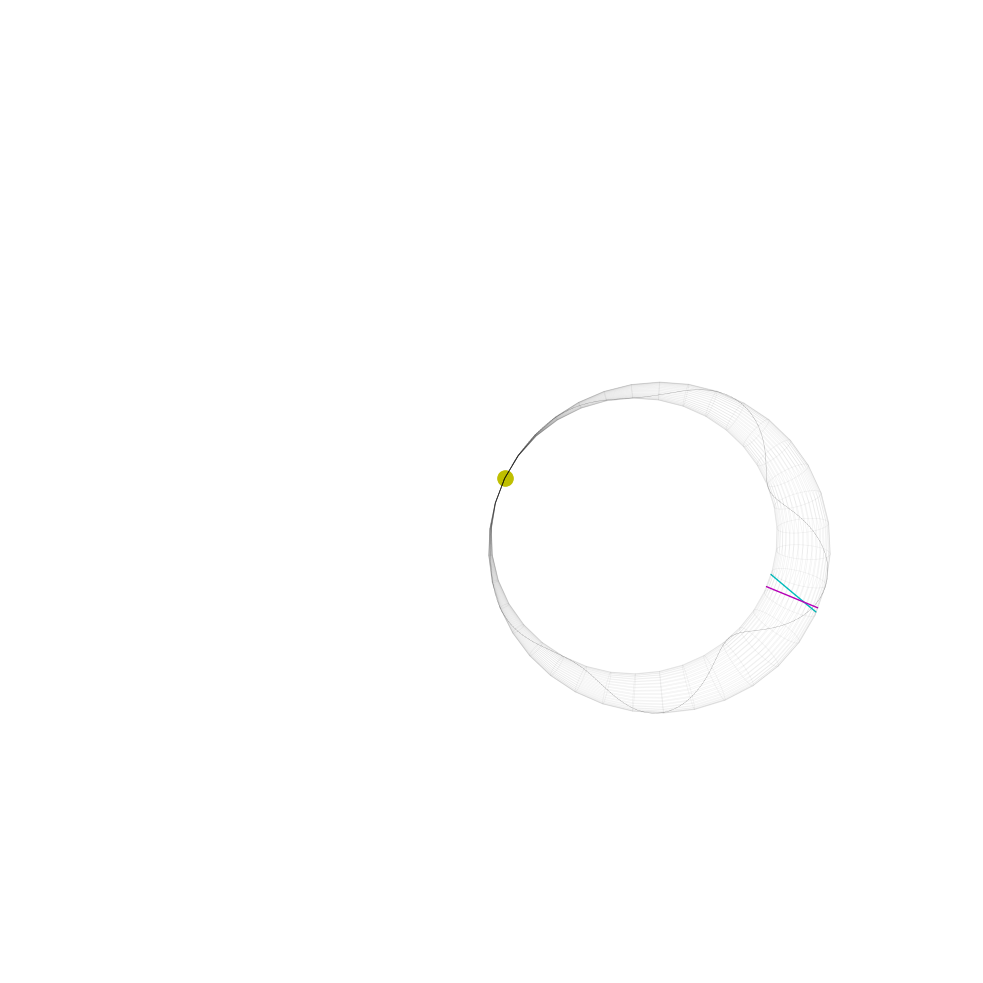

In [29]:
fig = plt.figure(figsize=(20, 20),dpi=50)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=80, view_elev=75, view_radius=.05)

plot_3dcore(ax, model_obj, TP_A, color=C0)
plot_3dcore_field(ax, model_obj, color=C0, steps=400, step_size=0.0005, lw=.5, ls=":")

plot_reconstruction(ax, model_obj, QPATH_PSP, color="c", ls="-", lw=2)
plot_reconstruction(ax, model_obj, QPATH_PSP_FIXED, color="m", ls="-", lw=2)

plt.tight_layout()

### make animation

### Play with model settings

In [30]:
############### Model Settings
t_launch = datetime.datetime(2022, 6, 1, 20)

iparams_arr = np.array([[
    0,      # time offset
    145,    # l_1 (longitude)
    2.5,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    300,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=5)
TP_B =  t_launch + datetime.timedelta(hours=24)

t1, btot1, bxyz1 = measure(model_obj, "PSP", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN")
t2, btot2, bxyz2 = measure(model_obj, "PSP", TP_B - datetime.timedelta(hours=12), TP_B  + datetime.timedelta(hours=12), frame="ECLIPJ2000", bframe="SPP_RTN")
tf, btotf, bxyzf = measure(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN", satparams=TP_A)

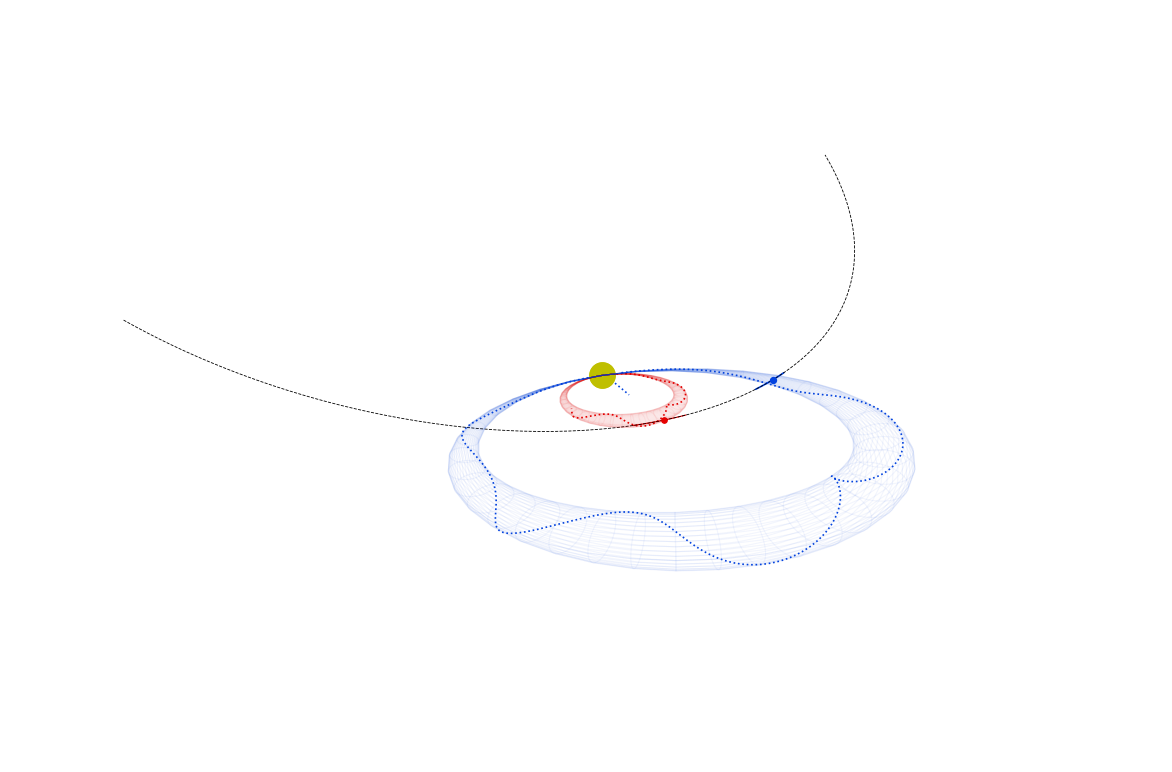

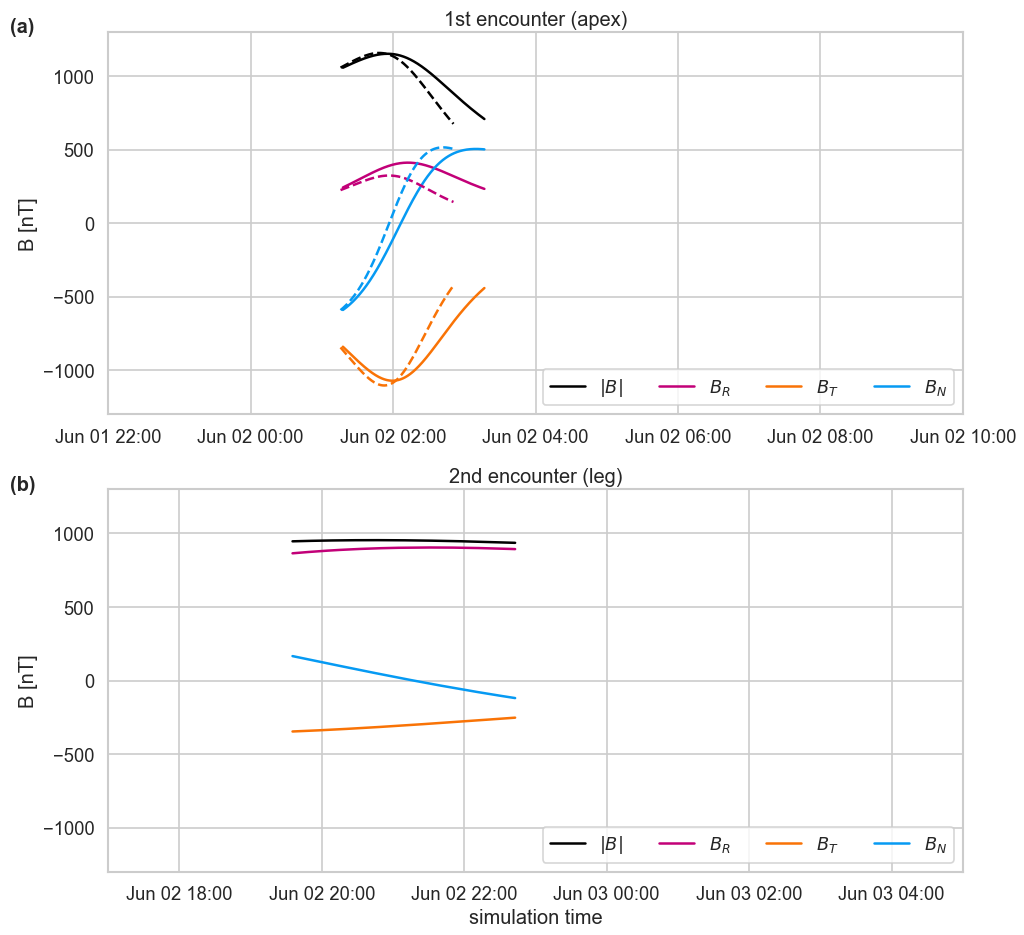

In [31]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 10),dpi=80)

ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=125, view_elev=40, view_radius=.15)
#plot_configure(ax, view_azim=125, view_elev=35, view_radius=.04)

plot_3dcore(ax, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax, model_obj, color=C_A, steps=300, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax, model_obj, color=C_B, steps=1500, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()


#########################################

sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(13, 12),dpi=80)

ax1 = fig.add_subplot(211)
ax1.set_title("1st encounter (apex)")

ax1.plot(t1, btot1, color=C0, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

ax1.plot(tf, btotf, color=C0, linestyle='--')
ax1.plot(tf, bxyzf[:, 0], color=C1, linestyle='--')
ax1.plot(tf, bxyzf[:, 1], color=C2, linestyle='--')
ax1.plot(tf, bxyzf[:, 2], color=C3, linestyle='--')

ax1.legend(loc="lower right", fontsize=16,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax1.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,1,22,0),datetime.datetime(2022,6,2,10,0))



ax2 = fig.add_subplot(212)
ax2.set_title("2nd encounter (leg)")

ax2.plot(t2, btot2, color=C0, label="$|B|$")
ax2.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax2.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax2.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")

ax2.legend(loc="lower right", fontsize=16,ncol=4)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax2.set_xlabel('simulation time')
ax2.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,2,17,0),datetime.datetime(2022,6,3,5,0))


plt.tight_layout()


plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold')

plt.savefig('results/plots_rate/fig6_3dcore_components_v0_300kms.png', dpi=300)
# plt.savefig('results/plots_rate/fig6_3dcore_components.png', dpi=300)

# 6 just for fun Dst distribution prediction and number of major geomagnetic storms

(-200, 50)

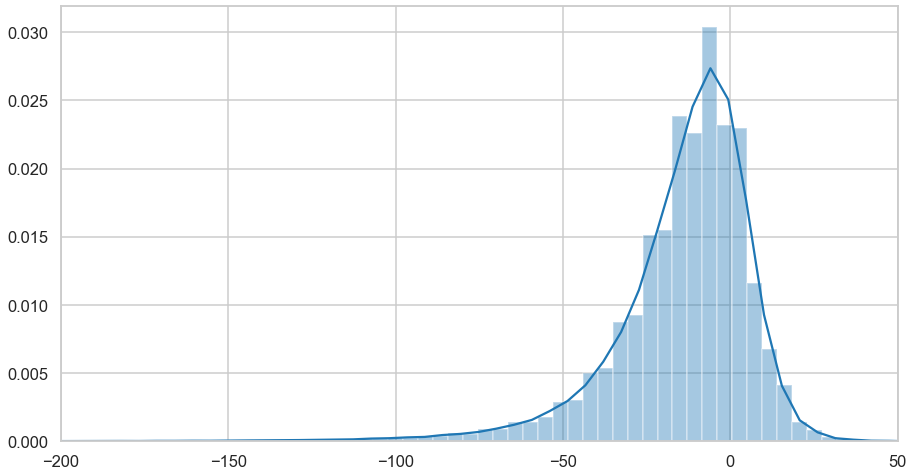

In [32]:
#distribution of sunspot number

#a=ssn.spot_mean_12.notnull()
#sns.distplot(ssn.spot_mean_12[a])

#distribution of dst since 1963
b=np.where(np.isnan(omni.dst)==False)
sns.distplot(omni.dst[b],bins=150)
plt.xlim(-200,50)